In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = True

In [4]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [5]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [6]:
epoch = 250

In [7]:
root = 'src/data/black_box_controller/exploratory_penality'

In [8]:
def train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name):
    if train:
        spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=activation), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
    trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
    evaluator_ddpg = env()
    history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()

    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)
    
    print("MSE :", loss_ddpg)

    log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
    axs[0].set_ylabel('AvergeEpRet')
    axs[0].legend()
    axs[2].set_xlabel('Epoch')

    axs[1].plot(log['LossPi'])
    axs[1].set_ylabel('Actor loss')
    axs[2].set_xlabel('Epoch')

    axs[2].plot(log['LossQ'])
    axs[2].set_ylabel('Critic loss')
    axs[2].set_xlabel('Epoch')

    fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

    axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
    axs[0].plot(t, test_trajectory[0, :], label='target')
    axs[0].set_ylabel('Ball position x [m]')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].legend()

    axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
    axs[1].plot(t, test_trajectory[1, :], label='target')
    axs[1].set_ylabel('Ball position y [m]')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].legend()

    axs[2].plot(t, error_ddpg[0, :], label='x')
    axs[2].plot(t, error_ddpg[1, :], label='y')
    axs[2].set_ylabel('Ball error [m]')
    axs[2].set_ylim([-MAX_X, MAX_X])
    axs[2].legend()

    axs[3].plot(t, angle_ddpg[0, :], label='angle_ddpg')
    axs[3].plot(t, u_ddpg[0, :], label='u_ddpg')
    axs[3].set_ylabel('Motor x angle [deg]')
    axs[3].legend()

    axs[4].plot(t, angle_ddpg[1, :], label='angle_ddpg')
    axs[4].plot(t, u_ddpg[1, :], label='u_ddpg')
    axs[4].set_xlabel('Time [s]')
    axs[4].set_ylabel('Motor y angle [deg]')
    axs[4].legend()

    plt.show()

Logging data to src/data/black_box_controller/exploratory_penality/pep_0.3_[100]_relu/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f8cf3320c88>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/pep_0.3_[100]_relu",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/pep_0.3_[100]_relu/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        

/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            73.9 |
|          StdEpRet |            26.4 |
|          MaxEpRet |            93.6 |
|          MinEpRet |            36.6 |
|  AverageTestEpRet |           -1.18 |
|      StdTestEpRet |            16.5 |
|      MaxTestEpRet |            29.1 |
|      MinTestEpRet |           -36.8 |
|             EpLen |             277 |
|         TestEpLen |            74.7 |
| TotalEnvInteracts |         1.1e+03 |
|      AverageQVals |          0.0233 |
|          StdQVals |           0.711 |
|          MaxQVals |            29.9 |
|          MinQVals |           -5.01 |
|            LossPi |         -0.0989 |
|             LossQ |           0.176 |
|              Time |            1.29 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |            11.7 |
|          StdEpRet |              20 |


---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |              47 |
|          StdEpRet |            92.2 |
|          MaxEpRet |             135 |
|          MinEpRet |           -96.2 |
|  AverageTestEpRet |            78.2 |
|      StdTestEpRet |              86 |
|      MaxTestEpRet |             251 |
|      MinTestEpRet |           -28.2 |
|             EpLen |             326 |
|         TestEpLen |             286 |
| TotalEnvInteracts |        1.21e+04 |
|      AverageQVals |            10.8 |
|          StdQVals |            14.3 |
|          MaxQVals |            44.2 |
|          MinQVals |           -29.3 |
|            LossPi |           -10.9 |
|             LossQ |             0.5 |
|              Time |            82.8 |
---------------------------------------
---------------------------------------
|             Epoch |              12 |
|      AverageEpRet |            57.9 |
|          StdEpRet |            52.2 |


---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |            35.2 |
|          StdEpRet |            51.6 |
|          MaxEpRet |             134 |
|          MinEpRet |           -21.8 |
|  AverageTestEpRet |            17.9 |
|      StdTestEpRet |              34 |
|      MaxTestEpRet |             100 |
|      MinTestEpRet |           -33.1 |
|             EpLen |             156 |
|         TestEpLen |             138 |
| TotalEnvInteracts |        2.31e+04 |
|      AverageQVals |            19.3 |
|          StdQVals |            22.2 |
|          MaxQVals |            61.2 |
|          MinQVals |             -52 |
|            LossPi |           -19.5 |
|             LossQ |            1.67 |
|              Time |             172 |
---------------------------------------
---------------------------------------
|             Epoch |              22 |
|      AverageEpRet |            12.1 |
|          StdEpRet |            21.8 |


---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |            65.1 |
|          StdEpRet |              85 |
|          MaxEpRet |             219 |
|          MinEpRet |           -42.8 |
|  AverageTestEpRet |             143 |
|      StdTestEpRet |            84.5 |
|      MaxTestEpRet |             267 |
|      MinTestEpRet |              12 |
|             EpLen |             207 |
|         TestEpLen |             304 |
| TotalEnvInteracts |        3.41e+04 |
|      AverageQVals |            29.6 |
|          StdQVals |            25.2 |
|          MaxQVals |            70.7 |
|          MinQVals |           -54.4 |
|            LossPi |           -29.9 |
|             LossQ |            2.07 |
|              Time |             274 |
---------------------------------------
---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |              73 |
|          StdEpRet |             110 |


---------------------------------------
|             Epoch |              41 |
|      AverageEpRet |             195 |
|          StdEpRet |             103 |
|          MaxEpRet |             286 |
|          MinEpRet |            19.4 |
|  AverageTestEpRet |             229 |
|      StdTestEpRet |            86.6 |
|      MaxTestEpRet |             307 |
|      MinTestEpRet |            19.8 |
|             EpLen |             332 |
|         TestEpLen |             367 |
| TotalEnvInteracts |        4.51e+04 |
|      AverageQVals |            41.5 |
|          StdQVals |            25.7 |
|          MaxQVals |            86.9 |
|          MinQVals |           -62.5 |
|            LossPi |           -41.9 |
|             LossQ |            1.88 |
|              Time |             388 |
---------------------------------------
---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |             188 |
|          StdEpRet |            59.9 |


---------------------------------------
|             Epoch |              51 |
|      AverageEpRet |             184 |
|          StdEpRet |            89.8 |
|          MaxEpRet |             254 |
|          MinEpRet |            57.6 |
|  AverageTestEpRet |             256 |
|      StdTestEpRet |            51.5 |
|      MaxTestEpRet |             299 |
|      MinTestEpRet |            39.7 |
|             EpLen |             400 |
|         TestEpLen |             386 |
| TotalEnvInteracts |        5.61e+04 |
|      AverageQVals |            49.4 |
|          StdQVals |            25.3 |
|          MaxQVals |            89.2 |
|          MinQVals |           -63.7 |
|            LossPi |           -49.7 |
|             LossQ |             2.2 |
|              Time |             494 |
---------------------------------------
---------------------------------------
|             Epoch |              52 |
|      AverageEpRet |             263 |
|          StdEpRet |            8.76 |


---------------------------------------
|             Epoch |              61 |
|      AverageEpRet |             254 |
|          StdEpRet |            30.6 |
|          MaxEpRet |             278 |
|          MinEpRet |             211 |
|  AverageTestEpRet |             252 |
|      StdTestEpRet |            16.8 |
|      MaxTestEpRet |             297 |
|      MinTestEpRet |             229 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.71e+04 |
|      AverageQVals |            56.8 |
|          StdQVals |            24.8 |
|          MaxQVals |             114 |
|          MinQVals |           -53.2 |
|            LossPi |           -57.1 |
|             LossQ |            2.25 |
|              Time |             606 |
---------------------------------------
---------------------------------------
|             Epoch |              62 |
|      AverageEpRet |             254 |
|          StdEpRet |            19.5 |


---------------------------------------
|             Epoch |              71 |
|      AverageEpRet |             269 |
|          StdEpRet |            0.55 |
|          MaxEpRet |             270 |
|          MinEpRet |             269 |
|  AverageTestEpRet |             265 |
|      StdTestEpRet |            20.8 |
|      MaxTestEpRet |             301 |
|      MinTestEpRet |             222 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.81e+04 |
|      AverageQVals |            61.4 |
|          StdQVals |            23.6 |
|          MaxQVals |             101 |
|          MinQVals |           -45.4 |
|            LossPi |           -61.8 |
|             LossQ |            1.83 |
|              Time |             729 |
---------------------------------------
---------------------------------------
|             Epoch |              72 |
|      AverageEpRet |             252 |
|          StdEpRet |            20.8 |


---------------------------------------
|             Epoch |              81 |
|      AverageEpRet |             252 |
|          StdEpRet |            21.6 |
|          MaxEpRet |             278 |
|          MinEpRet |             225 |
|  AverageTestEpRet |             254 |
|      StdTestEpRet |            22.1 |
|      MaxTestEpRet |             283 |
|      MinTestEpRet |             187 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.91e+04 |
|      AverageQVals |            64.6 |
|          StdQVals |            22.7 |
|          MaxQVals |             105 |
|          MinQVals |           -44.8 |
|            LossPi |             -65 |
|             LossQ |            1.84 |
|              Time |             850 |
---------------------------------------
---------------------------------------
|             Epoch |              82 |
|      AverageEpRet |             264 |
|          StdEpRet |            11.6 |


---------------------------------------
|             Epoch |              91 |
|      AverageEpRet |             277 |
|          StdEpRet |            10.3 |
|          MaxEpRet |             287 |
|          MinEpRet |             267 |
|  AverageTestEpRet |             269 |
|      StdTestEpRet |            39.1 |
|      MaxTestEpRet |             314 |
|      MinTestEpRet |             160 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |           1e+05 |
|      AverageQVals |              67 |
|          StdQVals |            21.9 |
|          MaxQVals |             111 |
|          MinQVals |           -36.7 |
|            LossPi |           -67.3 |
|             LossQ |            1.66 |
|              Time |             946 |
---------------------------------------
---------------------------------------
|             Epoch |              92 |
|      AverageEpRet |             248 |
|          StdEpRet |              53 |


---------------------------------------
|             Epoch |             101 |
|      AverageEpRet |             245 |
|          StdEpRet |            7.41 |
|          MaxEpRet |             253 |
|          MinEpRet |             235 |
|  AverageTestEpRet |             254 |
|      StdTestEpRet |            37.3 |
|      MaxTestEpRet |             308 |
|      MinTestEpRet |             182 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.11e+05 |
|      AverageQVals |            68.8 |
|          StdQVals |            21.5 |
|          MaxQVals |             121 |
|          MinQVals |           -38.8 |
|            LossPi |           -69.1 |
|             LossQ |            1.67 |
|              Time |        1.02e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             102 |
|      AverageEpRet |             276 |
|          StdEpRet |            9.84 |


---------------------------------------
|             Epoch |             111 |
|      AverageEpRet |             299 |
|          StdEpRet |            1.85 |
|          MaxEpRet |             301 |
|          MinEpRet |             297 |
|  AverageTestEpRet |             290 |
|      StdTestEpRet |            24.1 |
|      MaxTestEpRet |             318 |
|      MinTestEpRet |             229 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.22e+05 |
|      AverageQVals |            71.1 |
|          StdQVals |            21.3 |
|          MaxQVals |             114 |
|          MinQVals |           -55.6 |
|            LossPi |           -71.4 |
|             LossQ |            1.53 |
|              Time |         1.1e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             112 |
|      AverageEpRet |             271 |
|          StdEpRet |            21.9 |


---------------------------------------
|             Epoch |             121 |
|      AverageEpRet |             282 |
|          StdEpRet |            18.2 |
|          MaxEpRet |             304 |
|          MinEpRet |             260 |
|  AverageTestEpRet |             275 |
|      StdTestEpRet |            19.5 |
|      MaxTestEpRet |             327 |
|      MinTestEpRet |             239 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.33e+05 |
|      AverageQVals |            72.6 |
|          StdQVals |            20.8 |
|          MaxQVals |             125 |
|          MinQVals |           -36.4 |
|            LossPi |           -72.8 |
|             LossQ |            1.32 |
|              Time |        1.18e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             122 |
|      AverageEpRet |             288 |
|          StdEpRet |             1.6 |


---------------------------------------
|             Epoch |             131 |
|      AverageEpRet |             229 |
|          StdEpRet |            15.9 |
|          MaxEpRet |             244 |
|          MinEpRet |             213 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            16.4 |
|      MaxTestEpRet |             322 |
|      MinTestEpRet |             262 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.44e+05 |
|      AverageQVals |            72.9 |
|          StdQVals |              20 |
|          MaxQVals |             108 |
|          MinQVals |           -35.2 |
|            LossPi |           -73.1 |
|             LossQ |            1.25 |
|              Time |        1.25e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             132 |
|      AverageEpRet |             248 |
|          StdEpRet |            17.3 |


---------------------------------------
|             Epoch |             141 |
|      AverageEpRet |             273 |
|          StdEpRet |            16.4 |
|          MaxEpRet |             289 |
|          MinEpRet |             250 |
|  AverageTestEpRet |             254 |
|      StdTestEpRet |            16.7 |
|      MaxTestEpRet |             289 |
|      MinTestEpRet |             216 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.55e+05 |
|      AverageQVals |            74.1 |
|          StdQVals |            19.4 |
|          MaxQVals |             109 |
|          MinQVals |           -58.9 |
|            LossPi |           -74.3 |
|             LossQ |            1.18 |
|              Time |        1.32e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             142 |
|      AverageEpRet |             267 |
|          StdEpRet |            18.6 |


---------------------------------------
|             Epoch |             151 |
|      AverageEpRet |             270 |
|          StdEpRet |            18.6 |
|          MaxEpRet |             288 |
|          MinEpRet |             251 |
|  AverageTestEpRet |             273 |
|      StdTestEpRet |            32.6 |
|      MaxTestEpRet |             328 |
|      MinTestEpRet |             224 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.66e+05 |
|      AverageQVals |            75.6 |
|          StdQVals |            18.9 |
|          MaxQVals |             111 |
|          MinQVals |           -32.2 |
|            LossPi |           -75.9 |
|             LossQ |            1.12 |
|              Time |        1.39e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             152 |
|      AverageEpRet |             257 |
|          StdEpRet |            24.5 |


---------------------------------------
|             Epoch |             161 |
|      AverageEpRet |             287 |
|          StdEpRet |            27.7 |
|          MaxEpRet |             308 |
|          MinEpRet |             248 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |            26.2 |
|      MaxTestEpRet |             328 |
|      MinTestEpRet |             217 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.77e+05 |
|      AverageQVals |            76.4 |
|          StdQVals |            18.4 |
|          MaxQVals |             107 |
|          MinQVals |           -42.9 |
|            LossPi |           -76.6 |
|             LossQ |            1.14 |
|              Time |        1.46e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             162 |
|      AverageEpRet |             281 |
|          StdEpRet |            27.5 |


---------------------------------------
|             Epoch |             171 |
|      AverageEpRet |             288 |
|          StdEpRet |            5.79 |
|          MaxEpRet |             293 |
|          MinEpRet |             282 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            12.2 |
|      MaxTestEpRet |             315 |
|      MinTestEpRet |             276 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.88e+05 |
|      AverageQVals |            77.1 |
|          StdQVals |            18.1 |
|          MaxQVals |             179 |
|          MinQVals |           -47.7 |
|            LossPi |           -77.3 |
|             LossQ |            1.14 |
|              Time |        1.52e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             172 |
|      AverageEpRet |             282 |
|          StdEpRet |            11.6 |


---------------------------------------
|             Epoch |             181 |
|      AverageEpRet |             264 |
|          StdEpRet |            28.8 |
|          MaxEpRet |             298 |
|          MinEpRet |             227 |
|  AverageTestEpRet |             291 |
|      StdTestEpRet |              21 |
|      MaxTestEpRet |             323 |
|      MinTestEpRet |             245 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.99e+05 |
|      AverageQVals |            77.3 |
|          StdQVals |            17.6 |
|          MaxQVals |             105 |
|          MinQVals |           -38.6 |
|            LossPi |           -77.5 |
|             LossQ |            1.04 |
|              Time |        1.59e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             182 |
|      AverageEpRet |             285 |
|          StdEpRet |            29.6 |


---------------------------------------
|             Epoch |             191 |
|      AverageEpRet |             266 |
|          StdEpRet |            0.31 |
|          MaxEpRet |             266 |
|          MinEpRet |             266 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            18.9 |
|      MaxTestEpRet |             324 |
|      MinTestEpRet |             264 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.1e+05 |
|      AverageQVals |            77.1 |
|          StdQVals |            16.9 |
|          MaxQVals |             135 |
|          MinQVals |           -32.7 |
|            LossPi |           -77.3 |
|             LossQ |            1.03 |
|              Time |        1.65e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             192 |
|      AverageEpRet |             286 |
|          StdEpRet |            21.9 |


---------------------------------------
|             Epoch |             201 |
|      AverageEpRet |             277 |
|          StdEpRet |            4.15 |
|          MaxEpRet |             280 |
|          MinEpRet |             271 |
|  AverageTestEpRet |             274 |
|      StdTestEpRet |            27.2 |
|      MaxTestEpRet |             312 |
|      MinTestEpRet |             214 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.21e+05 |
|      AverageQVals |              76 |
|          StdQVals |            16.3 |
|          MaxQVals |             141 |
|          MinQVals |             -36 |
|            LossPi |           -76.2 |
|             LossQ |           0.962 |
|              Time |        1.72e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             202 |
|      AverageEpRet |             280 |
|          StdEpRet |            15.4 |


---------------------------------------
|             Epoch |             211 |
|      AverageEpRet |             184 |
|          StdEpRet |             141 |
|          MaxEpRet |             299 |
|          MinEpRet |           -13.8 |
|  AverageTestEpRet |             290 |
|      StdTestEpRet |            20.9 |
|      MaxTestEpRet |             317 |
|      MinTestEpRet |             234 |
|             EpLen |             314 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.32e+05 |
|      AverageQVals |            75.7 |
|          StdQVals |            15.7 |
|          MaxQVals |            99.1 |
|          MinQVals |           -27.8 |
|            LossPi |           -75.9 |
|             LossQ |             0.8 |
|              Time |        1.78e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             212 |
|      AverageEpRet |             272 |
|          StdEpRet |            9.28 |


---------------------------------------
|             Epoch |             221 |
|      AverageEpRet |             301 |
|          StdEpRet |            2.66 |
|          MaxEpRet |             303 |
|          MinEpRet |             298 |
|  AverageTestEpRet |             290 |
|      StdTestEpRet |              31 |
|      MaxTestEpRet |             326 |
|      MinTestEpRet |             217 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.43e+05 |
|      AverageQVals |            75.7 |
|          StdQVals |            15.4 |
|          MaxQVals |             126 |
|          MinQVals |           -27.9 |
|            LossPi |           -75.8 |
|             LossQ |           0.894 |
|              Time |        1.85e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             222 |
|      AverageEpRet |             281 |
|          StdEpRet |            15.4 |


---------------------------------------
|             Epoch |             231 |
|      AverageEpRet |             266 |
|          StdEpRet |              12 |
|          MaxEpRet |             278 |
|          MinEpRet |             249 |
|  AverageTestEpRet |             295 |
|      StdTestEpRet |            21.8 |
|      MaxTestEpRet |             328 |
|      MinTestEpRet |             231 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.54e+05 |
|      AverageQVals |            75.7 |
|          StdQVals |            15.2 |
|          MaxQVals |             110 |
|          MinQVals |           -29.9 |
|            LossPi |           -75.9 |
|             LossQ |           0.838 |
|              Time |        1.91e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             232 |
|      AverageEpRet |             295 |
|          StdEpRet |            7.57 |


---------------------------------------
|             Epoch |             241 |
|      AverageEpRet |             275 |
|          StdEpRet |            16.5 |
|          MaxEpRet |             292 |
|          MinEpRet |             259 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            28.1 |
|      MaxTestEpRet |             330 |
|      MinTestEpRet |             239 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.65e+05 |
|      AverageQVals |              76 |
|          StdQVals |            15.2 |
|          MaxQVals |            98.8 |
|          MinQVals |           -29.6 |
|            LossPi |           -76.1 |
|             LossQ |           0.695 |
|              Time |        1.97e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             242 |
|      AverageEpRet |             290 |
|          StdEpRet |            12.5 |


{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.06045717, -0.01103049], dtype=float32), array([ 0.06521074, -0.05038948], dtype=float32), array([0.00263777, 0.00137885], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.0010398196659237927


<IPython.core.display.Javascript object>


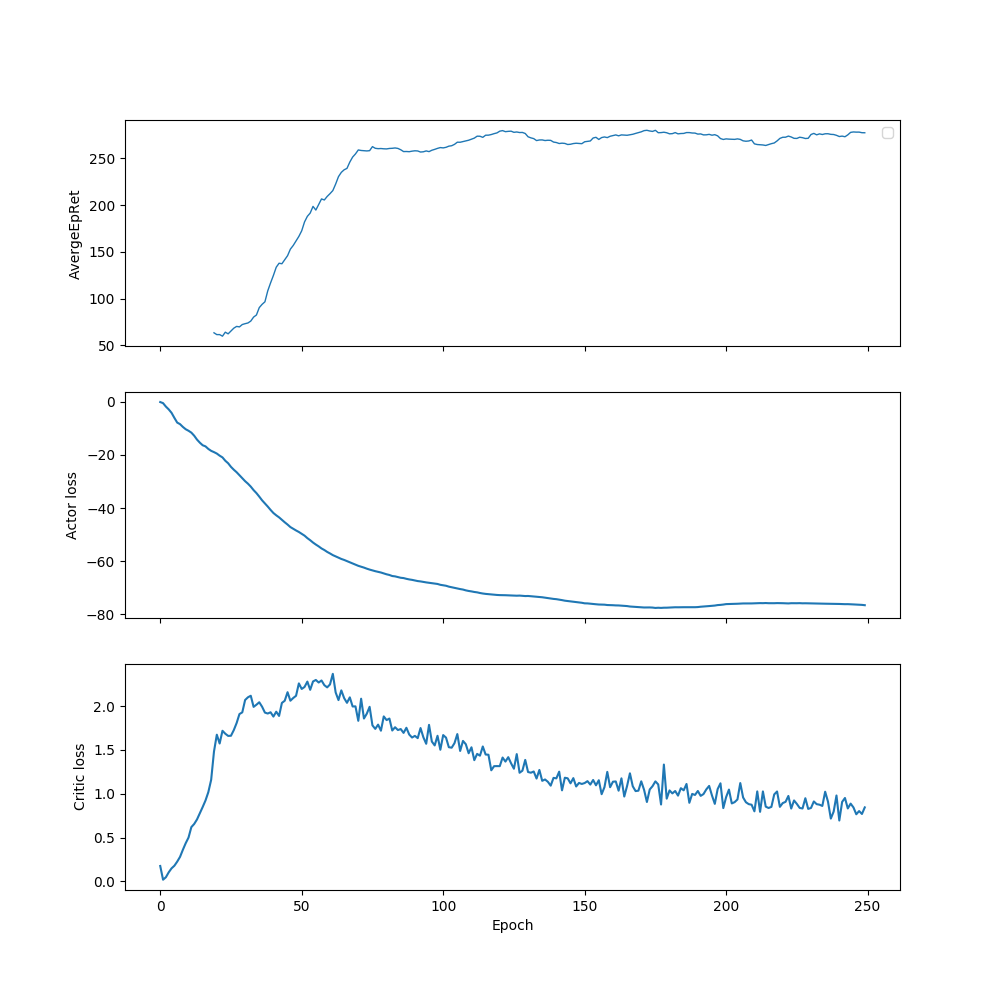

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


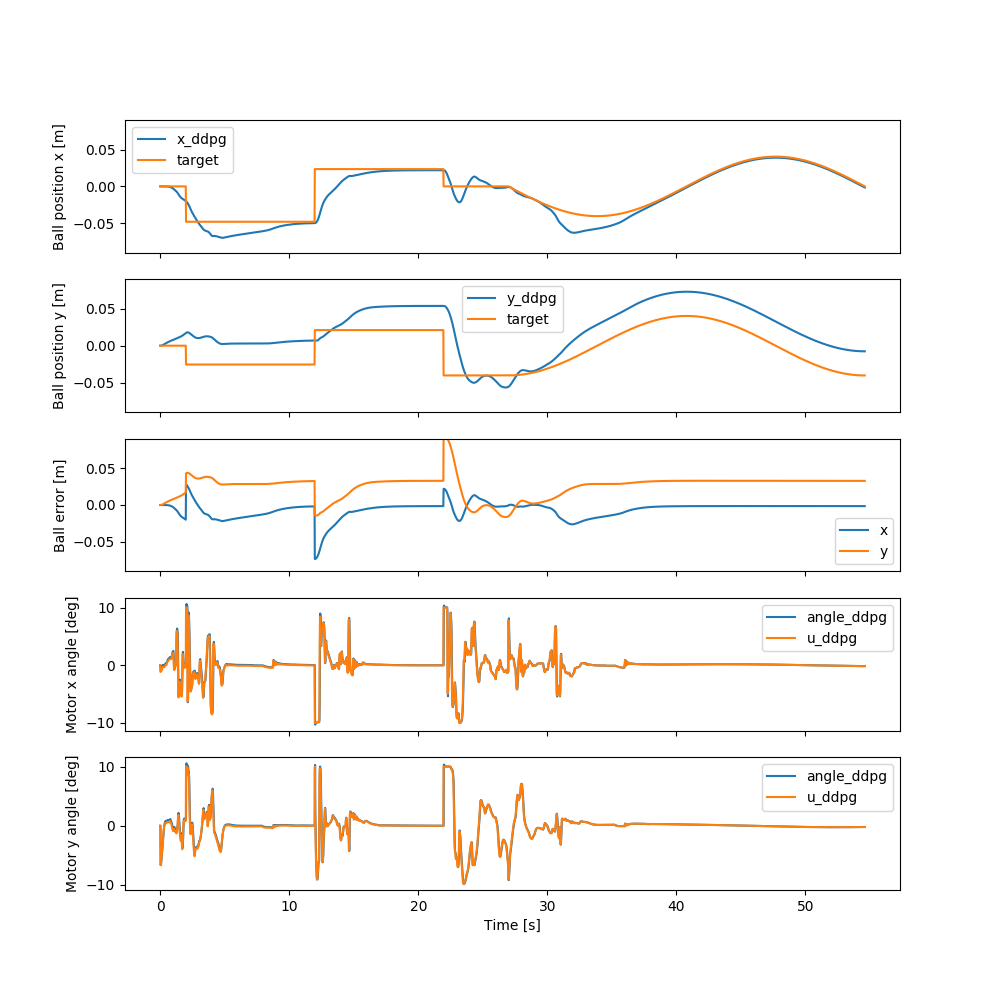

In [9]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
activation = torch.nn.ReLU
name='pep_0.3_[100]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/pep_0.45_[100]_relu/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f825eedfc50>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/pep_0.45_[100]_relu",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/pep_0.45_[100]_relu/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
     

/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            95.8 |
|          StdEpRet |            64.4 |
|          MaxEpRet |             160 |
|          MinEpRet |            7.67 |
|  AverageTestEpRet |            2.85 |
|      StdTestEpRet |            18.2 |
|      MaxTestEpRet |            39.3 |
|      MinTestEpRet |           -33.4 |
|             EpLen |             307 |
|         TestEpLen |            72.6 |
| TotalEnvInteracts |         1.1e+03 |
|      AverageQVals |           0.205 |
|          StdQVals |           0.489 |
|          MaxQVals |            14.8 |
|          MinQVals |             -14 |
|            LossPi |          -0.266 |
|             LossQ |            0.11 |
|              Time |            3.47 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |              73 |
|          StdEpRet |            49.8 |


---------------------------------------
|             Epoch |              11 |
|      AverageEpRet |              29 |
|          StdEpRet |            49.4 |
|          MaxEpRet |             106 |
|          MinEpRet |           -21.5 |
|  AverageTestEpRet |            80.9 |
|      StdTestEpRet |            56.7 |
|      MaxTestEpRet |             181 |
|      MinTestEpRet |           -6.58 |
|             EpLen |             276 |
|         TestEpLen |             204 |
| TotalEnvInteracts |        1.21e+04 |
|      AverageQVals |            16.3 |
|          StdQVals |            12.7 |
|          MaxQVals |            46.7 |
|          MinQVals |           -18.7 |
|            LossPi |           -16.5 |
|             LossQ |           0.315 |
|              Time |            62.5 |
---------------------------------------
---------------------------------------
|             Epoch |              12 |
|      AverageEpRet |           -64.7 |
|          StdEpRet |             0.2 |


---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |            28.1 |
|          StdEpRet |            45.6 |
|          MaxEpRet |            81.7 |
|          MinEpRet |           -22.2 |
|  AverageTestEpRet |            69.5 |
|      StdTestEpRet |            42.1 |
|      MaxTestEpRet |             125 |
|      MinTestEpRet |           -19.1 |
|             EpLen |             161 |
|         TestEpLen |             168 |
| TotalEnvInteracts |        2.31e+04 |
|      AverageQVals |            22.4 |
|          StdQVals |            20.9 |
|          MaxQVals |            63.4 |
|          MinQVals |           -28.1 |
|            LossPi |           -22.6 |
|             LossQ |           0.757 |
|              Time |             127 |
---------------------------------------
---------------------------------------
|             Epoch |              22 |
|      AverageEpRet |            77.9 |
|          StdEpRet |            16.5 |


---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |             119 |
|          StdEpRet |            63.5 |
|          MaxEpRet |             207 |
|          MinEpRet |            34.3 |
|  AverageTestEpRet |            67.6 |
|      StdTestEpRet |            32.1 |
|      MaxTestEpRet |             115 |
|      MinTestEpRet |            18.2 |
|             EpLen |             241 |
|         TestEpLen |             176 |
| TotalEnvInteracts |        3.41e+04 |
|      AverageQVals |            26.5 |
|          StdQVals |            25.1 |
|          MaxQVals |            78.6 |
|          MinQVals |           -30.3 |
|            LossPi |           -26.7 |
|             LossQ |            1.01 |
|              Time |             197 |
---------------------------------------
---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |            25.8 |
|          StdEpRet |            39.5 |


---------------------------------------
|             Epoch |              41 |
|      AverageEpRet |             126 |
|          StdEpRet |              37 |
|          MaxEpRet |             162 |
|          MinEpRet |            75.3 |
|  AverageTestEpRet |             140 |
|      StdTestEpRet |            89.6 |
|      MaxTestEpRet |             291 |
|      MinTestEpRet |           0.838 |
|             EpLen |             353 |
|         TestEpLen |             284 |
| TotalEnvInteracts |        4.51e+04 |
|      AverageQVals |            29.3 |
|          StdQVals |            25.6 |
|          MaxQVals |            82.1 |
|          MinQVals |           -44.5 |
|            LossPi |           -29.6 |
|             LossQ |            1.31 |
|              Time |             271 |
---------------------------------------
---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |             160 |
|          StdEpRet |             106 |


---------------------------------------
|             Epoch |              51 |
|      AverageEpRet |            97.2 |
|          StdEpRet |            84.6 |
|          MaxEpRet |             192 |
|          MinEpRet |           -13.5 |
|  AverageTestEpRet |             120 |
|      StdTestEpRet |            56.7 |
|      MaxTestEpRet |             249 |
|      MinTestEpRet |            18.2 |
|             EpLen |             326 |
|         TestEpLen |             332 |
| TotalEnvInteracts |        5.61e+04 |
|      AverageQVals |            33.5 |
|          StdQVals |            25.4 |
|          MaxQVals |            86.7 |
|          MinQVals |           -50.7 |
|            LossPi |           -33.7 |
|             LossQ |            1.56 |
|              Time |             350 |
---------------------------------------
---------------------------------------
|             Epoch |              52 |
|      AverageEpRet |             113 |
|          StdEpRet |            40.1 |


---------------------------------------
|             Epoch |              61 |
|      AverageEpRet |             258 |
|          StdEpRet |            26.6 |
|          MaxEpRet |             294 |
|          MinEpRet |             229 |
|  AverageTestEpRet |             236 |
|      StdTestEpRet |            86.4 |
|      MaxTestEpRet |             318 |
|      MinTestEpRet |            27.4 |
|             EpLen |             400 |
|         TestEpLen |             377 |
| TotalEnvInteracts |        6.71e+04 |
|      AverageQVals |              39 |
|          StdQVals |            25.1 |
|          MaxQVals |            92.9 |
|          MinQVals |           -88.1 |
|            LossPi |           -39.2 |
|             LossQ |            1.51 |
|              Time |             418 |
---------------------------------------
---------------------------------------
|             Epoch |              62 |
|      AverageEpRet |             188 |
|          StdEpRet |             142 |


---------------------------------------
|             Epoch |              71 |
|      AverageEpRet |             195 |
|          StdEpRet |             167 |
|          MaxEpRet |             317 |
|          MinEpRet |           -41.9 |
|  AverageTestEpRet |             289 |
|      StdTestEpRet |            17.2 |
|      MaxTestEpRet |             313 |
|      MinTestEpRet |             247 |
|             EpLen |             310 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.81e+04 |
|      AverageQVals |            45.8 |
|          StdQVals |            25.9 |
|          MaxQVals |              89 |
|          MinQVals |           -47.5 |
|            LossPi |           -46.2 |
|             LossQ |            1.47 |
|              Time |             485 |
---------------------------------------
---------------------------------------
|             Epoch |              72 |
|      AverageEpRet |             263 |
|          StdEpRet |            10.1 |


---------------------------------------
|             Epoch |              81 |
|      AverageEpRet |             289 |
|          StdEpRet |            41.9 |
|          MaxEpRet |             321 |
|          MinEpRet |             230 |
|  AverageTestEpRet |             284 |
|      StdTestEpRet |            53.2 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |             120 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.91e+04 |
|      AverageQVals |            53.7 |
|          StdQVals |            26.3 |
|          MaxQVals |            98.4 |
|          MinQVals |           -59.8 |
|            LossPi |             -54 |
|             LossQ |            1.49 |
|              Time |             548 |
---------------------------------------
---------------------------------------
|             Epoch |              82 |
|      AverageEpRet |             304 |
|          StdEpRet |            8.53 |


---------------------------------------
|             Epoch |              91 |
|      AverageEpRet |             289 |
|          StdEpRet |            8.74 |
|          MaxEpRet |             301 |
|          MinEpRet |             280 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            16.8 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             279 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |           1e+05 |
|      AverageQVals |              60 |
|          StdQVals |            26.1 |
|          MaxQVals |             123 |
|          MinQVals |             -47 |
|            LossPi |           -60.4 |
|             LossQ |            1.41 |
|              Time |             615 |
---------------------------------------
---------------------------------------
|             Epoch |              92 |
|      AverageEpRet |             274 |
|          StdEpRet |            10.3 |


---------------------------------------
|             Epoch |             101 |
|      AverageEpRet |             269 |
|          StdEpRet |            19.6 |
|          MaxEpRet |             297 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             282 |
|      StdTestEpRet |            27.7 |
|      MaxTestEpRet |             321 |
|      MinTestEpRet |             234 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.11e+05 |
|      AverageQVals |            64.5 |
|          StdQVals |            25.8 |
|          MaxQVals |             108 |
|          MinQVals |           -31.4 |
|            LossPi |           -64.8 |
|             LossQ |            1.49 |
|              Time |             684 |
---------------------------------------
---------------------------------------
|             Epoch |             102 |
|      AverageEpRet |             272 |
|          StdEpRet |            16.6 |


---------------------------------------
|             Epoch |             111 |
|      AverageEpRet |             274 |
|          StdEpRet |            18.8 |
|          MaxEpRet |             299 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            31.2 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |             207 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.22e+05 |
|      AverageQVals |            67.8 |
|          StdQVals |              25 |
|          MaxQVals |             132 |
|          MinQVals |           -27.7 |
|            LossPi |           -68.1 |
|             LossQ |            1.44 |
|              Time |             748 |
---------------------------------------
---------------------------------------
|             Epoch |             112 |
|      AverageEpRet |             257 |
|          StdEpRet |            9.73 |


---------------------------------------
|             Epoch |             121 |
|      AverageEpRet |             271 |
|          StdEpRet |            8.16 |
|          MaxEpRet |             282 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             282 |
|      StdTestEpRet |            34.1 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |             186 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.33e+05 |
|      AverageQVals |            70.6 |
|          StdQVals |            23.8 |
|          MaxQVals |             132 |
|          MinQVals |           -33.1 |
|            LossPi |           -70.9 |
|             LossQ |            1.41 |
|              Time |             815 |
---------------------------------------
---------------------------------------
|             Epoch |             122 |
|      AverageEpRet |             292 |
|          StdEpRet |            15.3 |


---------------------------------------
|             Epoch |             131 |
|      AverageEpRet |             272 |
|          StdEpRet |            26.9 |
|          MaxEpRet |             298 |
|          MinEpRet |             245 |
|  AverageTestEpRet |             296 |
|      StdTestEpRet |            27.8 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             232 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.44e+05 |
|      AverageQVals |            71.9 |
|          StdQVals |              23 |
|          MaxQVals |             138 |
|          MinQVals |           -24.5 |
|            LossPi |           -72.1 |
|             LossQ |            1.24 |
|              Time |             877 |
---------------------------------------
---------------------------------------
|             Epoch |             132 |
|      AverageEpRet |             271 |
|          StdEpRet |              20 |


---------------------------------------
|             Epoch |             141 |
|      AverageEpRet |             246 |
|          StdEpRet |            38.9 |
|          MaxEpRet |             296 |
|          MinEpRet |             201 |
|  AverageTestEpRet |             278 |
|      StdTestEpRet |            35.2 |
|      MaxTestEpRet |             327 |
|      MinTestEpRet |             151 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.55e+05 |
|      AverageQVals |            72.1 |
|          StdQVals |            22.7 |
|          MaxQVals |             117 |
|          MinQVals |           -25.4 |
|            LossPi |           -72.4 |
|             LossQ |            1.23 |
|              Time |             943 |
---------------------------------------
---------------------------------------
|             Epoch |             142 |
|      AverageEpRet |             279 |
|          StdEpRet |            18.1 |


---------------------------------------
|             Epoch |             151 |
|      AverageEpRet |             255 |
|          StdEpRet |            26.8 |
|          MaxEpRet |             282 |
|          MinEpRet |             228 |
|  AverageTestEpRet |             275 |
|      StdTestEpRet |            25.8 |
|      MaxTestEpRet |             313 |
|      MinTestEpRet |             190 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.66e+05 |
|      AverageQVals |            72.9 |
|          StdQVals |            22.2 |
|          MaxQVals |             103 |
|          MinQVals |           -24.7 |
|            LossPi |           -73.1 |
|             LossQ |            1.04 |
|              Time |        1.01e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             152 |
|      AverageEpRet |             283 |
|          StdEpRet |            10.5 |


---------------------------------------
|             Epoch |             161 |
|      AverageEpRet |             289 |
|          StdEpRet |            1.48 |
|          MaxEpRet |             291 |
|          MinEpRet |             287 |
|  AverageTestEpRet |             251 |
|      StdTestEpRet |            22.5 |
|      MaxTestEpRet |             283 |
|      MinTestEpRet |             194 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.77e+05 |
|      AverageQVals |            73.5 |
|          StdQVals |            21.8 |
|          MaxQVals |             143 |
|          MinQVals |           -83.6 |
|            LossPi |           -73.7 |
|             LossQ |             1.3 |
|              Time |        1.08e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             162 |
|      AverageEpRet |             243 |
|          StdEpRet |            24.6 |


---------------------------------------
|             Epoch |             171 |
|      AverageEpRet |             287 |
|          StdEpRet |            8.08 |
|          MaxEpRet |             295 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             274 |
|      StdTestEpRet |            66.4 |
|      MaxTestEpRet |             316 |
|      MinTestEpRet |           -4.16 |
|             EpLen |             400 |
|         TestEpLen |             388 |
| TotalEnvInteracts |        1.88e+05 |
|      AverageQVals |            74.1 |
|          StdQVals |            21.7 |
|          MaxQVals |             124 |
|          MinQVals |             -34 |
|            LossPi |           -74.4 |
|             LossQ |            1.03 |
|              Time |        1.14e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             172 |
|      AverageEpRet |             262 |
|          StdEpRet |            22.8 |


---------------------------------------
|             Epoch |             181 |
|      AverageEpRet |             279 |
|          StdEpRet |            4.88 |
|          MaxEpRet |             283 |
|          MinEpRet |             272 |
|  AverageTestEpRet |             281 |
|      StdTestEpRet |            25.9 |
|      MaxTestEpRet |             318 |
|      MinTestEpRet |             232 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.99e+05 |
|      AverageQVals |            75.1 |
|          StdQVals |            20.7 |
|          MaxQVals |             109 |
|          MinQVals |           -18.3 |
|            LossPi |           -75.3 |
|             LossQ |            1.05 |
|              Time |        1.21e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             182 |
|      AverageEpRet |             297 |
|          StdEpRet |            7.05 |


---------------------------------------
|             Epoch |             191 |
|      AverageEpRet |             269 |
|          StdEpRet |            12.2 |
|          MaxEpRet |             281 |
|          MinEpRet |             257 |
|  AverageTestEpRet |             279 |
|      StdTestEpRet |              67 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |           -5.56 |
|             EpLen |             400 |
|         TestEpLen |             387 |
| TotalEnvInteracts |         2.1e+05 |
|      AverageQVals |            75.3 |
|          StdQVals |            19.7 |
|          MaxQVals |             121 |
|          MinQVals |           -19.4 |
|            LossPi |           -75.5 |
|             LossQ |            1.08 |
|              Time |        1.27e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             192 |
|      AverageEpRet |             257 |
|          StdEpRet |            17.9 |


---------------------------------------
|             Epoch |             201 |
|      AverageEpRet |             268 |
|          StdEpRet |            34.8 |
|          MaxEpRet |             310 |
|          MinEpRet |             225 |
|  AverageTestEpRet |             288 |
|      StdTestEpRet |            18.8 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |             257 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.21e+05 |
|      AverageQVals |            75.5 |
|          StdQVals |            19.1 |
|          MaxQVals |             125 |
|          MinQVals |           -24.5 |
|            LossPi |           -75.7 |
|             LossQ |           0.851 |
|              Time |        1.34e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             202 |
|      AverageEpRet |             276 |
|          StdEpRet |            7.77 |


---------------------------------------
|             Epoch |             211 |
|      AverageEpRet |             299 |
|          StdEpRet |            8.39 |
|          MaxEpRet |             307 |
|          MinEpRet |             291 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            24.9 |
|      MaxTestEpRet |             325 |
|      MinTestEpRet |             230 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.32e+05 |
|      AverageQVals |            75.8 |
|          StdQVals |            18.7 |
|          MaxQVals |             103 |
|          MinQVals |           -18.8 |
|            LossPi |           -76.1 |
|             LossQ |           0.756 |
|              Time |        1.41e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             212 |
|      AverageEpRet |             297 |
|          StdEpRet |            22.4 |


---------------------------------------
|             Epoch |             221 |
|      AverageEpRet |             286 |
|          StdEpRet |            6.93 |
|          MaxEpRet |             293 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             284 |
|      StdTestEpRet |            59.7 |
|      MaxTestEpRet |             325 |
|      MinTestEpRet |            34.2 |
|             EpLen |             400 |
|         TestEpLen |             386 |
| TotalEnvInteracts |        2.43e+05 |
|      AverageQVals |            76.7 |
|          StdQVals |            18.3 |
|          MaxQVals |             106 |
|          MinQVals |           -15.5 |
|            LossPi |           -76.9 |
|             LossQ |           0.808 |
|              Time |        1.47e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             222 |
|      AverageEpRet |             279 |
|          StdEpRet |            24.8 |


---------------------------------------
|             Epoch |             231 |
|      AverageEpRet |             254 |
|          StdEpRet |              30 |
|          MaxEpRet |             279 |
|          MinEpRet |             212 |
|  AverageTestEpRet |             301 |
|      StdTestEpRet |            18.8 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |             268 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.54e+05 |
|      AverageQVals |            76.7 |
|          StdQVals |            17.8 |
|          MaxQVals |            97.6 |
|          MinQVals |             -18 |
|            LossPi |           -76.9 |
|             LossQ |           0.646 |
|              Time |        1.54e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             232 |
|      AverageEpRet |             299 |
|          StdEpRet |            2.76 |


---------------------------------------
|             Epoch |             241 |
|      AverageEpRet |             299 |
|          StdEpRet |            18.1 |
|          MaxEpRet |             317 |
|          MinEpRet |             281 |
|  AverageTestEpRet |             305 |
|      StdTestEpRet |              17 |
|      MaxTestEpRet |             330 |
|      MinTestEpRet |             274 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.65e+05 |
|      AverageQVals |            76.6 |
|          StdQVals |            17.4 |
|          MaxQVals |             108 |
|          MinQVals |           -16.3 |
|            LossPi |           -76.8 |
|             LossQ |           0.652 |
|              Time |         1.6e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             242 |
|      AverageEpRet |             294 |
|          StdEpRet |            9.69 |


{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.02824936, 0.02784804], dtype=float32), array([0.04801561, 0.04900571], dtype=float32), array([-4.9167011e-05,  1.7551392e-03], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.0011015520497543523


<IPython.core.display.Javascript object>


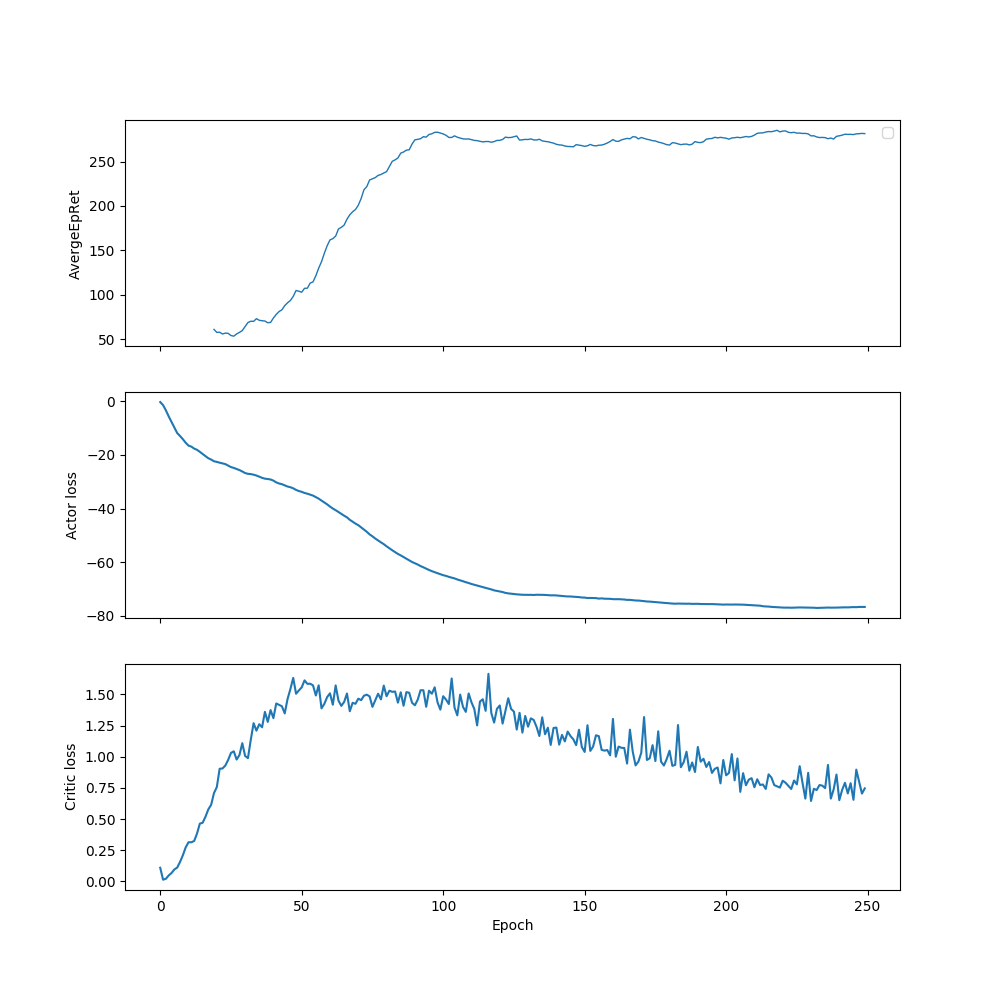

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


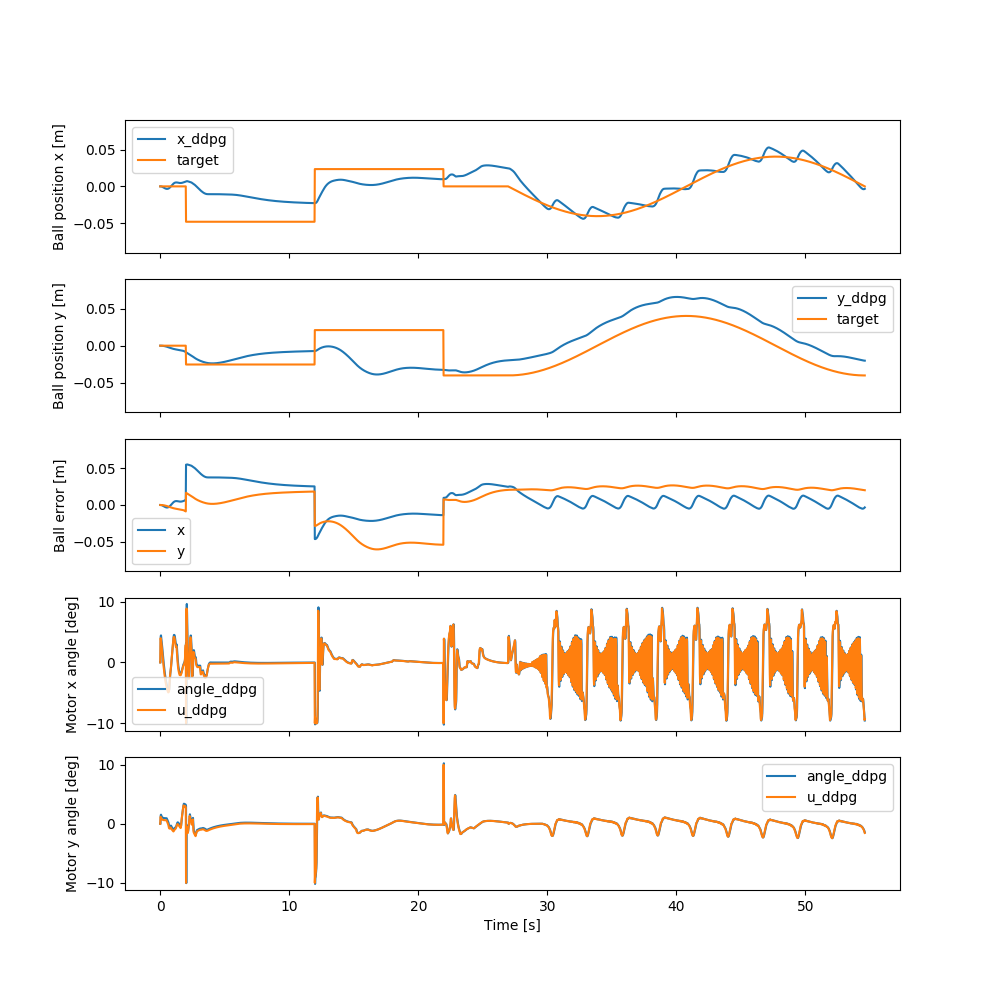

In [9]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.45
hidden_size = [100]
activation = torch.nn.ReLU
name='pep_0.45_[100]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/pep_0.6_[100]_relu/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f8cf2700ac8>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/pep_0.6_[100]_relu",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/pep_0.6_[100]_relu/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |            65.6 |
|          StdEpRet |            43.6 |
|          MaxEpRet |            96.1 |
|          MinEpRet |           -9.22 |
|  AverageTestEpRet |            89.8 |
|      StdTestEpRet |            56.9 |
|      MaxTestEpRet |             196 |
|      MinTestEpRet |            8.21 |
|             EpLen |             300 |
|         TestEpLen |             192 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |            9.75 |
|          StdQVals |            7.13 |
|          MaxQVals |            33.3 |
|          MinQVals |           -9.52 |
|            LossPi |           -9.96 |
|             LossQ |          0.0964 |
|              Time |            30.8 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            23.2 |
|          StdEpRet |            45.6 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |              26 |
|          StdEpRet |            18.5 |
|          MaxEpRet |            48.7 |
|          MinEpRet |           -1.23 |
|  AverageTestEpRet |            86.2 |
|      StdTestEpRet |            41.3 |
|      MaxTestEpRet |             189 |
|      MinTestEpRet |            17.4 |
|             EpLen |             142 |
|         TestEpLen |             186 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |            23.3 |
|          StdQVals |            16.7 |
|          MaxQVals |            56.8 |
|          MinQVals |           -27.4 |
|            LossPi |           -23.5 |
|             LossQ |           0.485 |
|              Time |            83.6 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             134 |
|          StdEpRet |            28.4 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |            83.8 |
|          StdEpRet |            78.4 |
|          MaxEpRet |             212 |
|          MinEpRet |             5.7 |
|  AverageTestEpRet |             107 |
|      StdTestEpRet |            63.7 |
|      MaxTestEpRet |             309 |
|      MinTestEpRet |            32.4 |
|             EpLen |             216 |
|         TestEpLen |             220 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |            28.6 |
|          StdQVals |            22.8 |
|          MaxQVals |            75.9 |
|          MinQVals |           -24.2 |
|            LossPi |           -28.8 |
|             LossQ |            0.87 |
|              Time |             139 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             146 |
|          StdEpRet |            13.5 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |             165 |
|          StdEpRet |            51.7 |
|          MaxEpRet |             236 |
|          MinEpRet |            99.7 |
|  AverageTestEpRet |             102 |
|      StdTestEpRet |            55.3 |
|      MaxTestEpRet |             258 |
|      MinTestEpRet |            18.9 |
|             EpLen |             350 |
|         TestEpLen |             247 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |            32.3 |
|          StdQVals |            25.4 |
|          MaxQVals |            83.1 |
|          MinQVals |           -29.9 |
|            LossPi |           -32.5 |
|             LossQ |             1.1 |
|              Time |             196 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |            79.1 |
|          StdEpRet |            47.3 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |             157 |
|          StdEpRet |            81.5 |
|          MaxEpRet |             301 |
|          MinEpRet |            73.1 |
|  AverageTestEpRet |             103 |
|      StdTestEpRet |            61.4 |
|      MaxTestEpRet |             251 |
|      MinTestEpRet |            11.8 |
|             EpLen |             272 |
|         TestEpLen |             227 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |            35.3 |
|          StdQVals |            26.4 |
|          MaxQVals |            87.7 |
|          MinQVals |             -35 |
|            LossPi |           -35.5 |
|             LossQ |            1.24 |
|              Time |             250 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             207 |
|          StdEpRet |            90.8 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |            70.1 |
|          StdEpRet |            39.5 |
|          MaxEpRet |             173 |
|          MinEpRet |            42.8 |
|  AverageTestEpRet |            81.8 |
|      StdTestEpRet |            42.5 |
|      MaxTestEpRet |             189 |
|      MinTestEpRet |           -15.8 |
|             EpLen |             147 |
|         TestEpLen |             180 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            39.8 |
|          StdQVals |            26.9 |
|          MaxQVals |            93.7 |
|          MinQVals |             -57 |
|            LossPi |             -40 |
|             LossQ |            1.79 |
|              Time |             304 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |            70.8 |
|          StdEpRet |            27.3 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |             268 |
|          StdEpRet |            23.6 |
|          MaxEpRet |             285 |
|          MinEpRet |             234 |
|  AverageTestEpRet |             283 |
|      StdTestEpRet |            29.8 |
|      MaxTestEpRet |             311 |
|      MinTestEpRet |             203 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |            43.5 |
|          StdQVals |            25.5 |
|          MaxQVals |            93.2 |
|          MinQVals |           -54.9 |
|            LossPi |           -43.8 |
|             LossQ |            1.91 |
|              Time |             366 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             280 |
|          StdEpRet |            15.3 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             258 |
|          StdEpRet |            56.6 |
|          MaxEpRet |             305 |
|          MinEpRet |             179 |
|  AverageTestEpRet |             253 |
|      StdTestEpRet |            82.7 |
|      MaxTestEpRet |             330 |
|      MinTestEpRet |            12.6 |
|             EpLen |             373 |
|         TestEpLen |             370 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            47.4 |
|          StdQVals |              25 |
|          MaxQVals |             104 |
|          MinQVals |           -48.4 |
|            LossPi |           -47.6 |
|             LossQ |            1.84 |
|              Time |             431 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             265 |
|          StdEpRet |            41.5 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             226 |
|          StdEpRet |             105 |
|          MaxEpRet |             310 |
|          MinEpRet |            47.4 |
|  AverageTestEpRet |             281 |
|      StdTestEpRet |            54.7 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |            83.4 |
|             EpLen |             324 |
|         TestEpLen |             383 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |              51 |
|          StdQVals |            25.4 |
|          MaxQVals |            98.8 |
|          MinQVals |           -40.2 |
|            LossPi |           -51.2 |
|             LossQ |            1.81 |
|              Time |             496 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             266 |
|          StdEpRet |            4.29 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             159 |
|          StdEpRet |             101 |
|          MaxEpRet |             265 |
|          MinEpRet |              23 |
|  AverageTestEpRet |             268 |
|      StdTestEpRet |            61.5 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |              16 |
|             EpLen |             270 |
|         TestEpLen |             384 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |              55 |
|          StdQVals |            25.5 |
|          MaxQVals |             106 |
|          MinQVals |           -34.5 |
|            LossPi |           -55.3 |
|             LossQ |            1.73 |
|              Time |             562 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             262 |
|          StdEpRet |            14.5 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |             211 |
|          StdEpRet |             103 |
|          MaxEpRet |             292 |
|          MinEpRet |            66.6 |
|  AverageTestEpRet |             256 |
|      StdTestEpRet |            86.5 |
|      MaxTestEpRet |             318 |
|      MinTestEpRet |            38.1 |
|             EpLen |             323 |
|         TestEpLen |             361 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            58.1 |
|          StdQVals |            25.2 |
|          MaxQVals |             111 |
|          MinQVals |           -31.5 |
|            LossPi |           -58.4 |
|             LossQ |            1.67 |
|              Time |             620 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             259 |
|          StdEpRet |            2.05 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |             278 |
|          StdEpRet |            14.5 |
|          MaxEpRet |             294 |
|          MinEpRet |             259 |
|  AverageTestEpRet |             255 |
|      StdTestEpRet |            84.1 |
|      MaxTestEpRet |             324 |
|      MinTestEpRet |           -22.5 |
|             EpLen |             400 |
|         TestEpLen |             363 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |            60.9 |
|          StdQVals |              25 |
|          MaxQVals |             104 |
|          MinQVals |           -27.7 |
|            LossPi |           -61.2 |
|             LossQ |            1.72 |
|              Time |             685 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             203 |
|          StdEpRet |            97.3 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             268 |
|          StdEpRet |            9.42 |
|          MaxEpRet |             275 |
|          MinEpRet |             255 |
|  AverageTestEpRet |             290 |
|      StdTestEpRet |            14.9 |
|      MaxTestEpRet |             318 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |              64 |
|          StdQVals |            24.3 |
|          MaxQVals |             159 |
|          MinQVals |           -58.5 |
|            LossPi |           -64.3 |
|             LossQ |            1.86 |
|              Time |             747 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             274 |
|          StdEpRet |            23.1 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             266 |
|          StdEpRet |              19 |
|          MaxEpRet |             285 |
|          MinEpRet |             247 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |              24 |
|      MaxTestEpRet |             325 |
|      MinTestEpRet |             226 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            66.2 |
|          StdQVals |            23.8 |
|          MaxQVals |             157 |
|          MinQVals |           -52.7 |
|            LossPi |           -66.4 |
|             LossQ |            1.86 |
|              Time |             809 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             274 |
|          StdEpRet |            37.1 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             287 |
|          StdEpRet |            26.9 |
|          MaxEpRet |             309 |
|          MinEpRet |             249 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            29.7 |
|      MaxTestEpRet |             331 |
|      MinTestEpRet |             194 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            67.8 |
|          StdQVals |            23.2 |
|          MaxQVals |             135 |
|          MinQVals |           -27.6 |
|            LossPi |           -68.1 |
|             LossQ |            1.65 |
|              Time |             871 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             288 |
|          StdEpRet |            13.4 |


---------------------------------------
|             Epoch |             157 |
|      AverageEpRet |             288 |
|          StdEpRet |            14.8 |
|          MaxEpRet |             303 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             297 |
|      StdTestEpRet |            12.3 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |             279 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.73e+05 |
|      AverageQVals |            69.4 |
|          StdQVals |            22.4 |
|          MaxQVals |             131 |
|          MinQVals |           -26.4 |
|            LossPi |           -69.7 |
|             LossQ |            1.53 |
|              Time |             936 |
---------------------------------------
---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             285 |
|          StdEpRet |            12.5 |


---------------------------------------
|             Epoch |             167 |
|      AverageEpRet |             274 |
|          StdEpRet |            10.2 |
|          MaxEpRet |             288 |
|          MinEpRet |             264 |
|  AverageTestEpRet |             265 |
|      StdTestEpRet |            25.4 |
|      MaxTestEpRet |             309 |
|      MinTestEpRet |             212 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.84e+05 |
|      AverageQVals |            70.6 |
|          StdQVals |            21.7 |
|          MaxQVals |             120 |
|          MinQVals |           -25.3 |
|            LossPi |           -70.8 |
|             LossQ |            1.51 |
|              Time |           1e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             258 |
|          StdEpRet |            17.2 |


---------------------------------------
|             Epoch |             177 |
|      AverageEpRet |             286 |
|          StdEpRet |           0.591 |
|          MaxEpRet |             287 |
|          MinEpRet |             285 |
|  AverageTestEpRet |             290 |
|      StdTestEpRet |            60.3 |
|      MaxTestEpRet |             328 |
|      MinTestEpRet |            54.1 |
|             EpLen |             400 |
|         TestEpLen |             387 |
| TotalEnvInteracts |        1.95e+05 |
|      AverageQVals |            71.8 |
|          StdQVals |            21.5 |
|          MaxQVals |             119 |
|          MinQVals |           -22.9 |
|            LossPi |           -72.1 |
|             LossQ |            1.38 |
|              Time |        1.07e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             274 |
|          StdEpRet |            13.1 |


---------------------------------------
|             Epoch |             187 |
|      AverageEpRet |             291 |
|          StdEpRet |            8.36 |
|          MaxEpRet |             302 |
|          MinEpRet |             281 |
|  AverageTestEpRet |             284 |
|      StdTestEpRet |            69.7 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |           -13.2 |
|             EpLen |             400 |
|         TestEpLen |             385 |
| TotalEnvInteracts |        2.06e+05 |
|      AverageQVals |            72.8 |
|          StdQVals |              21 |
|          MaxQVals |             134 |
|          MinQVals |           -33.5 |
|            LossPi |           -73.1 |
|             LossQ |            1.42 |
|              Time |        1.13e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             307 |
|          StdEpRet |           0.727 |


---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |             269 |
|          StdEpRet |            29.7 |
|          MaxEpRet |             295 |
|          MinEpRet |             228 |
|  AverageTestEpRet |             270 |
|      StdTestEpRet |            56.1 |
|      MaxTestEpRet |             314 |
|      MinTestEpRet |             136 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.17e+05 |
|      AverageQVals |            74.4 |
|          StdQVals |            20.2 |
|          MaxQVals |             113 |
|          MinQVals |           -33.7 |
|            LossPi |           -74.7 |
|             LossQ |            1.49 |
|              Time |         1.2e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             256 |
|          StdEpRet |            31.7 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |             275 |
|          StdEpRet |            33.6 |
|          MaxEpRet |             311 |
|          MinEpRet |             230 |
|  AverageTestEpRet |             285 |
|      StdTestEpRet |              34 |
|      MaxTestEpRet |             337 |
|      MinTestEpRet |             227 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.28e+05 |
|      AverageQVals |            75.6 |
|          StdQVals |            19.4 |
|          MaxQVals |             135 |
|          MinQVals |           -22.6 |
|            LossPi |           -75.9 |
|             LossQ |            1.47 |
|              Time |        1.26e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |             274 |
|          StdEpRet |            17.9 |


---------------------------------------
|             Epoch |             217 |
|      AverageEpRet |             256 |
|          StdEpRet |            3.11 |
|          MaxEpRet |             259 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             289 |
|      StdTestEpRet |            31.7 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             231 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.39e+05 |
|      AverageQVals |            76.3 |
|          StdQVals |            18.7 |
|          MaxQVals |             163 |
|          MinQVals |           -27.6 |
|            LossPi |           -76.6 |
|             LossQ |            1.43 |
|              Time |        1.32e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |             251 |
|          StdEpRet |            1.42 |


---------------------------------------
|             Epoch |             227 |
|      AverageEpRet |             279 |
|          StdEpRet |              28 |
|          MaxEpRet |             308 |
|          MinEpRet |             241 |
|  AverageTestEpRet |             279 |
|      StdTestEpRet |              29 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |             236 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.5e+05 |
|      AverageQVals |            75.9 |
|          StdQVals |            18.4 |
|          MaxQVals |             112 |
|          MinQVals |           -24.2 |
|            LossPi |           -76.1 |
|             LossQ |            1.36 |
|              Time |        1.39e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             228 |
|      AverageEpRet |             219 |
|          StdEpRet |            17.3 |


---------------------------------------
|             Epoch |             237 |
|      AverageEpRet |             285 |
|          StdEpRet |            16.9 |
|          MaxEpRet |             302 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             224 |
|      StdTestEpRet |            90.6 |
|      MaxTestEpRet |             305 |
|      MinTestEpRet |           -15.7 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.61e+05 |
|      AverageQVals |            75.9 |
|          StdQVals |              18 |
|          MaxQVals |             132 |
|          MinQVals |           -22.1 |
|            LossPi |           -76.1 |
|             LossQ |            1.37 |
|              Time |        1.45e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             238 |
|      AverageEpRet |             279 |
|          StdEpRet |            22.2 |


---------------------------------------
|             Epoch |             247 |
|      AverageEpRet |             257 |
|          StdEpRet |            26.6 |
|          MaxEpRet |             291 |
|          MinEpRet |             226 |
|  AverageTestEpRet |             270 |
|      StdTestEpRet |            30.8 |
|      MaxTestEpRet |             312 |
|      MinTestEpRet |             165 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.72e+05 |
|      AverageQVals |            76.3 |
|          StdQVals |            17.9 |
|          MaxQVals |             146 |
|          MinQVals |             -22 |
|            LossPi |           -76.5 |
|             LossQ |             1.2 |
|              Time |        1.51e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             248 |
|      AverageEpRet |             283 |
|          StdEpRet |             8.1 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.0016479786240419989


<IPython.core.display.Javascript object>


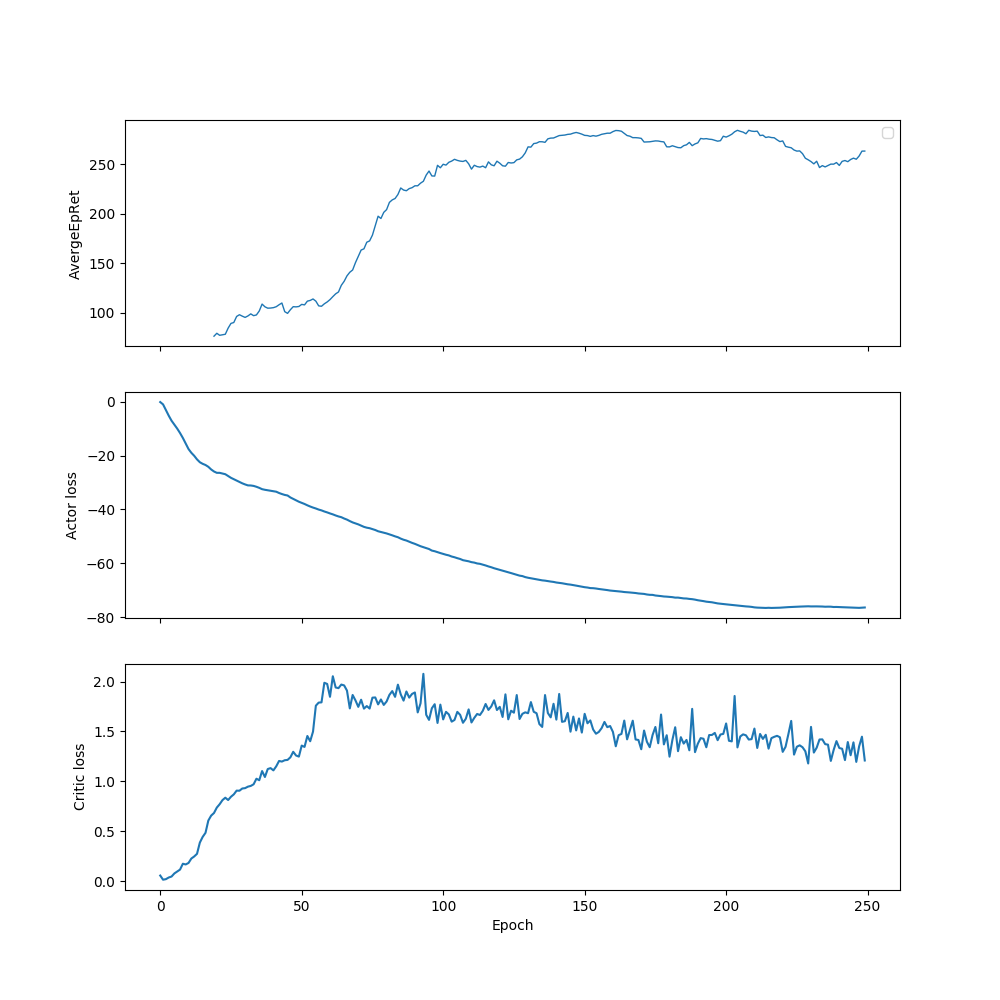

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


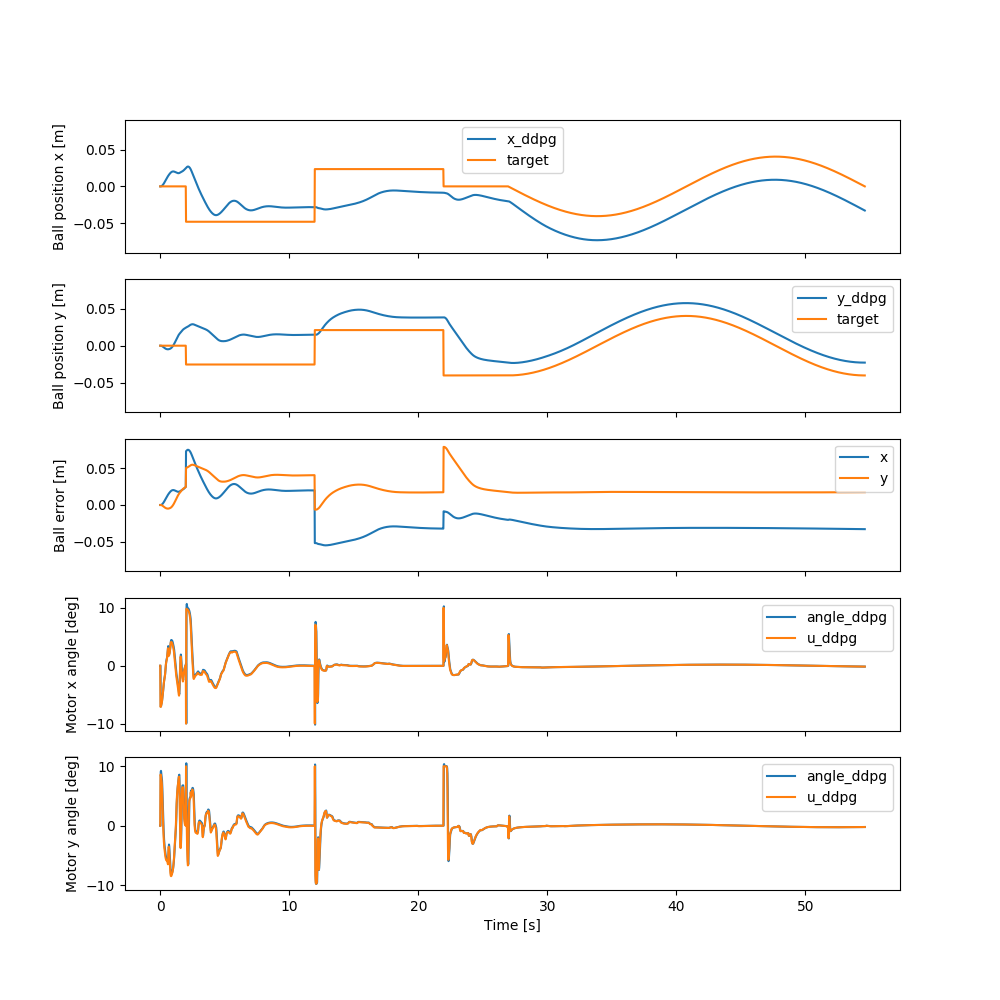

In [10]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.ReLU
name='pep_0.6_[100]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/pep_0.6_[100]_relu_no_bias/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"BlackBoxActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f825eedfba8>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/pep_0.6_[100]_relu_no_bias",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/pep_0.6_[100]_relu_no_bias/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
           

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |            45.3 |
|          StdEpRet |              28 |
|          MaxEpRet |            82.1 |
|          MinEpRet |            10.8 |
|  AverageTestEpRet |             115 |
|      StdTestEpRet |            50.4 |
|      MaxTestEpRet |             211 |
|      MinTestEpRet |            14.7 |
|             EpLen |             293 |
|         TestEpLen |             242 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |            11.6 |
|          StdQVals |            7.87 |
|          MaxQVals |            25.9 |
|          MinQVals |           -7.99 |
|            LossPi |           -11.9 |
|             LossQ |           0.099 |
|              Time |              31 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            80.5 |
|          StdEpRet |            59.6 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |            57.4 |
|          StdEpRet |            33.3 |
|          MaxEpRet |             107 |
|          MinEpRet |            18.8 |
|  AverageTestEpRet |             107 |
|      StdTestEpRet |            73.8 |
|      MaxTestEpRet |             332 |
|      MinTestEpRet |            36.2 |
|             EpLen |             214 |
|         TestEpLen |             235 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |            22.2 |
|          StdQVals |            17.3 |
|          MaxQVals |            54.8 |
|          MinQVals |           -35.9 |
|            LossPi |           -22.4 |
|             LossQ |           0.427 |
|              Time |            82.4 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |             102 |
|          StdEpRet |            81.8 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |             141 |
|          StdEpRet |              83 |
|          MaxEpRet |             264 |
|          MinEpRet |            48.2 |
|  AverageTestEpRet |             145 |
|      StdTestEpRet |            87.8 |
|      MaxTestEpRet |             312 |
|      MinTestEpRet |            14.9 |
|             EpLen |             276 |
|         TestEpLen |             258 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |            29.8 |
|          StdQVals |            21.9 |
|          MaxQVals |            71.5 |
|          MinQVals |           -31.8 |
|            LossPi |             -30 |
|             LossQ |           0.641 |
|              Time |             141 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             120 |
|          StdEpRet |            65.9 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |            70.9 |
|          StdEpRet |              47 |
|          MaxEpRet |             141 |
|          MinEpRet |            4.81 |
|  AverageTestEpRet |            93.7 |
|      StdTestEpRet |            57.2 |
|      MaxTestEpRet |             236 |
|      MinTestEpRet |            -5.1 |
|             EpLen |             205 |
|         TestEpLen |             242 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |            31.6 |
|          StdQVals |            24.9 |
|          MaxQVals |            80.7 |
|          MinQVals |           -29.6 |
|            LossPi |           -31.8 |
|             LossQ |           0.747 |
|              Time |             195 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |            84.7 |
|          StdEpRet |            39.1 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |             112 |
|          StdEpRet |            80.6 |
|          MaxEpRet |             236 |
|          MinEpRet |            19.1 |
|  AverageTestEpRet |             135 |
|      StdTestEpRet |            75.7 |
|      MaxTestEpRet |             316 |
|      MinTestEpRet |            63.8 |
|             EpLen |             265 |
|         TestEpLen |             258 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |            34.2 |
|          StdQVals |            25.5 |
|          MaxQVals |            84.2 |
|          MinQVals |             -22 |
|            LossPi |           -34.4 |
|             LossQ |           0.879 |
|              Time |             251 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |              63 |
|          StdEpRet |            41.3 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |             159 |
|          StdEpRet |            17.1 |
|          MaxEpRet |             181 |
|          MinEpRet |             140 |
|  AverageTestEpRet |             163 |
|      StdTestEpRet |            67.1 |
|      MaxTestEpRet |             266 |
|      MinTestEpRet |            34.7 |
|             EpLen |             365 |
|         TestEpLen |             312 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            34.6 |
|          StdQVals |            25.5 |
|          MaxQVals |            87.7 |
|          MinQVals |           -28.3 |
|            LossPi |           -34.8 |
|             LossQ |           0.981 |
|              Time |             306 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             139 |
|          StdEpRet |            90.9 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |             123 |
|          StdEpRet |            44.7 |
|          MaxEpRet |             196 |
|          MinEpRet |            81.2 |
|  AverageTestEpRet |            10.4 |
|      StdTestEpRet |            14.7 |
|      MaxTestEpRet |            35.6 |
|      MinTestEpRet |             -18 |
|             EpLen |             330 |
|         TestEpLen |            88.7 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |            38.1 |
|          StdQVals |            25.1 |
|          MaxQVals |             107 |
|          MinQVals |           -24.3 |
|            LossPi |           -38.3 |
|             LossQ |            1.01 |
|              Time |             362 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |            82.4 |
|          StdEpRet |            38.6 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             292 |
|          StdEpRet |            12.5 |
|          MaxEpRet |             309 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             260 |
|      StdTestEpRet |            19.9 |
|      MaxTestEpRet |             298 |
|      MinTestEpRet |             213 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            41.8 |
|          StdQVals |            24.7 |
|          MaxQVals |            97.3 |
|          MinQVals |           -38.8 |
|            LossPi |           -42.1 |
|             LossQ |            1.19 |
|              Time |             422 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             238 |
|          StdEpRet |            22.8 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             280 |
|          StdEpRet |            23.8 |
|          MaxEpRet |             310 |
|          MinEpRet |             252 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            64.2 |
|      MaxTestEpRet |             338 |
|      MinTestEpRet |              31 |
|             EpLen |             400 |
|         TestEpLen |             386 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |            47.5 |
|          StdQVals |            24.9 |
|          MaxQVals |             103 |
|          MinQVals |           -26.4 |
|            LossPi |           -47.8 |
|             LossQ |             1.3 |
|              Time |             484 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             301 |
|          StdEpRet |             7.7 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             267 |
|          StdEpRet |            15.4 |
|          MaxEpRet |             288 |
|          MinEpRet |             253 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            24.5 |
|      MaxTestEpRet |             327 |
|      MinTestEpRet |             246 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |            52.7 |
|          StdQVals |            25.5 |
|          MaxQVals |             103 |
|          MinQVals |           -22.7 |
|            LossPi |           -52.9 |
|             LossQ |            1.38 |
|              Time |             549 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             224 |
|          StdEpRet |            88.6 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |             276 |
|          StdEpRet |            14.3 |
|          MaxEpRet |             296 |
|          MinEpRet |             264 |
|  AverageTestEpRet |             298 |
|      StdTestEpRet |            27.4 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             236 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            55.8 |
|          StdQVals |            25.4 |
|          MaxQVals |             106 |
|          MinQVals |             -24 |
|            LossPi |           -56.1 |
|             LossQ |            1.44 |
|              Time |             611 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             298 |
|          StdEpRet |            11.7 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |             283 |
|          StdEpRet |            9.61 |
|          MaxEpRet |             293 |
|          MinEpRet |             274 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            17.6 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             273 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |            58.5 |
|          StdQVals |            24.7 |
|          MaxQVals |             105 |
|          MinQVals |           -24.4 |
|            LossPi |           -58.7 |
|             LossQ |            1.25 |
|              Time |             679 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             268 |
|          StdEpRet |            15.8 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             279 |
|          StdEpRet |            3.67 |
|          MaxEpRet |             283 |
|          MinEpRet |             274 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |            22.7 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             253 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |            61.7 |
|          StdQVals |            23.9 |
|          MaxQVals |             108 |
|          MinQVals |           -18.5 |
|            LossPi |           -61.9 |
|             LossQ |            1.31 |
|              Time |             743 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             302 |
|          StdEpRet |            1.93 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             276 |
|          StdEpRet |            20.1 |
|          MaxEpRet |             296 |
|          MinEpRet |             256 |
|  AverageTestEpRet |             312 |
|      StdTestEpRet |            14.4 |
|      MaxTestEpRet |             331 |
|      MinTestEpRet |             279 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            63.3 |
|          StdQVals |            23.4 |
|          MaxQVals |             112 |
|          MinQVals |           -19.3 |
|            LossPi |           -63.5 |
|             LossQ |            1.15 |
|              Time |             806 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             273 |
|          StdEpRet |            10.4 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             301 |
|          StdEpRet |            17.9 |
|          MaxEpRet |             321 |
|          MinEpRet |             277 |
|  AverageTestEpRet |             306 |
|      StdTestEpRet |            14.2 |
|      MaxTestEpRet |             324 |
|      MinTestEpRet |             276 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            64.7 |
|          StdQVals |            22.6 |
|          MaxQVals |             105 |
|          MinQVals |           -17.7 |
|            LossPi |           -64.9 |
|             LossQ |            1.09 |
|              Time |             870 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             290 |
|          StdEpRet |            24.4 |


---------------------------------------
|             Epoch |             157 |
|      AverageEpRet |             273 |
|          StdEpRet |            29.6 |
|          MaxEpRet |             303 |
|          MinEpRet |             243 |
|  AverageTestEpRet |             299 |
|      StdTestEpRet |            20.8 |
|      MaxTestEpRet |             336 |
|      MinTestEpRet |             266 |
|             EpLen |             388 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.73e+05 |
|      AverageQVals |            65.7 |
|          StdQVals |              22 |
|          MaxQVals |             158 |
|          MinQVals |           -26.1 |
|            LossPi |           -65.9 |
|             LossQ |            1.07 |
|              Time |             934 |
---------------------------------------
---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             283 |
|          StdEpRet |            23.9 |


---------------------------------------
|             Epoch |             167 |
|      AverageEpRet |             302 |
|          StdEpRet |            4.49 |
|          MaxEpRet |             307 |
|          MinEpRet |             296 |
|  AverageTestEpRet |             289 |
|      StdTestEpRet |            23.2 |
|      MaxTestEpRet |             325 |
|      MinTestEpRet |             225 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.84e+05 |
|      AverageQVals |            66.6 |
|          StdQVals |            21.9 |
|          MaxQVals |             142 |
|          MinQVals |           -20.2 |
|            LossPi |           -66.8 |
|             LossQ |               1 |
|              Time |             998 |
---------------------------------------
---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             297 |
|          StdEpRet |            11.3 |


---------------------------------------
|             Epoch |             177 |
|      AverageEpRet |             276 |
|          StdEpRet |            12.7 |
|          MaxEpRet |             289 |
|          MinEpRet |             263 |
|  AverageTestEpRet |             300 |
|      StdTestEpRet |            19.8 |
|      MaxTestEpRet |             325 |
|      MinTestEpRet |             258 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.95e+05 |
|      AverageQVals |            67.5 |
|          StdQVals |            21.7 |
|          MaxQVals |             125 |
|          MinQVals |           -81.8 |
|            LossPi |           -67.7 |
|             LossQ |            1.05 |
|              Time |        1.06e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             275 |
|          StdEpRet |            46.3 |


---------------------------------------
|             Epoch |             187 |
|      AverageEpRet |             285 |
|          StdEpRet |            17.3 |
|          MaxEpRet |             304 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             292 |
|      StdTestEpRet |            20.7 |
|      MaxTestEpRet |             323 |
|      MinTestEpRet |             248 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.06e+05 |
|      AverageQVals |            68.5 |
|          StdQVals |              21 |
|          MaxQVals |             139 |
|          MinQVals |           -35.3 |
|            LossPi |           -68.6 |
|             LossQ |           0.925 |
|              Time |        1.12e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             291 |
|          StdEpRet |            18.1 |


---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |             281 |
|          StdEpRet |            20.1 |
|          MaxEpRet |             301 |
|          MinEpRet |             261 |
|  AverageTestEpRet |             271 |
|      StdTestEpRet |              29 |
|      MaxTestEpRet |             319 |
|      MinTestEpRet |             187 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.17e+05 |
|      AverageQVals |            69.5 |
|          StdQVals |            20.3 |
|          MaxQVals |             162 |
|          MinQVals |           -40.4 |
|            LossPi |           -69.7 |
|             LossQ |            1.02 |
|              Time |        1.19e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             266 |
|          StdEpRet |            29.7 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |             290 |
|          StdEpRet |            23.2 |
|          MaxEpRet |             308 |
|          MinEpRet |             257 |
|  AverageTestEpRet |             304 |
|      StdTestEpRet |              29 |
|      MaxTestEpRet |             333 |
|      MinTestEpRet |             219 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.28e+05 |
|      AverageQVals |            70.5 |
|          StdQVals |            19.7 |
|          MaxQVals |             133 |
|          MinQVals |           -16.9 |
|            LossPi |           -70.7 |
|             LossQ |           0.889 |
|              Time |        1.25e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |             294 |
|          StdEpRet |            2.96 |


---------------------------------------
|             Epoch |             217 |
|      AverageEpRet |             300 |
|          StdEpRet |            1.79 |
|          MaxEpRet |             301 |
|          MinEpRet |             298 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |              28 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             235 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.39e+05 |
|      AverageQVals |            71.5 |
|          StdQVals |            19.4 |
|          MaxQVals |             119 |
|          MinQVals |           -13.3 |
|            LossPi |           -71.7 |
|             LossQ |            0.84 |
|              Time |        1.32e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |             273 |
|          StdEpRet |            58.6 |


---------------------------------------
|             Epoch |             227 |
|      AverageEpRet |             260 |
|          StdEpRet |            40.6 |
|          MaxEpRet |             311 |
|          MinEpRet |             212 |
|  AverageTestEpRet |             315 |
|      StdTestEpRet |            14.5 |
|      MaxTestEpRet |             331 |
|      MinTestEpRet |             283 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.5e+05 |
|      AverageQVals |            72.2 |
|          StdQVals |            18.9 |
|          MaxQVals |             148 |
|          MinQVals |           -16.3 |
|            LossPi |           -72.4 |
|             LossQ |           0.858 |
|              Time |        1.38e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             228 |
|      AverageEpRet |             301 |
|          StdEpRet |            25.5 |


---------------------------------------
|             Epoch |             237 |
|      AverageEpRet |             322 |
|          StdEpRet |            1.45 |
|          MaxEpRet |             323 |
|          MinEpRet |             320 |
|  AverageTestEpRet |             303 |
|      StdTestEpRet |            29.1 |
|      MaxTestEpRet |             329 |
|      MinTestEpRet |             229 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.61e+05 |
|      AverageQVals |            72.6 |
|          StdQVals |            18.6 |
|          MaxQVals |             121 |
|          MinQVals |           -15.9 |
|            LossPi |           -72.7 |
|             LossQ |           0.771 |
|              Time |        1.45e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             238 |
|      AverageEpRet |             307 |
|          StdEpRet |            11.8 |


---------------------------------------
|             Epoch |             247 |
|      AverageEpRet |             308 |
|          StdEpRet |            14.6 |
|          MaxEpRet |             323 |
|          MinEpRet |             288 |
|  AverageTestEpRet |             310 |
|      StdTestEpRet |            17.5 |
|      MaxTestEpRet |             335 |
|      MinTestEpRet |             277 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.72e+05 |
|      AverageQVals |            72.9 |
|          StdQVals |            18.3 |
|          MaxQVals |             117 |
|          MinQVals |             -16 |
|            LossPi |             -73 |
|             LossQ |           0.775 |
|              Time |        1.51e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             248 |
|      AverageEpRet |             296 |
|          StdEpRet |            3.91 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.002307770860393595


<IPython.core.display.Javascript object>


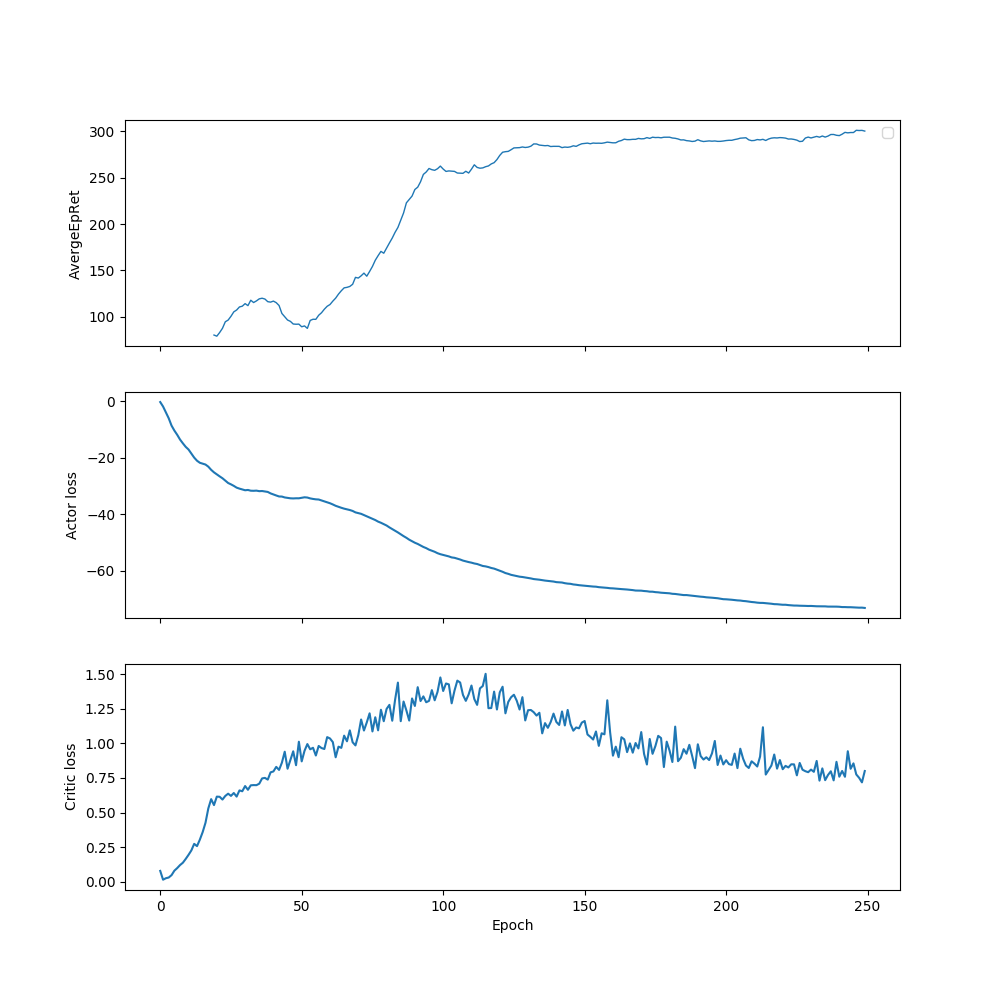

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


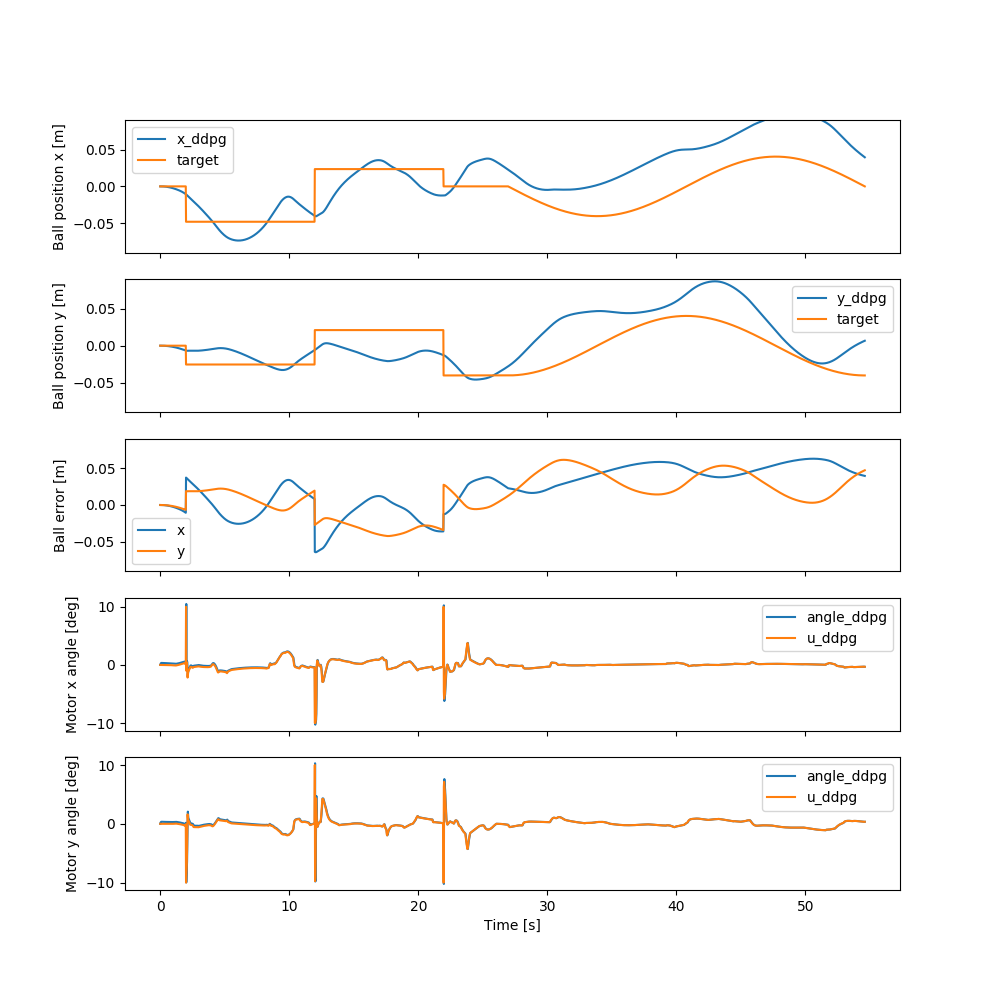

In [10]:
env = BBEnv
ac = BlackBoxActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.ReLU
name='pep_0.6_[100]_relu_no_bias'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnv
ac = BlackBoxActorCritic
reward_fn = linear_e_reward_penality
w = 0.4
hidden_size = [100]
activation = torch.nn.ReLU
name='lep_0.4_[100]_relu_no_bias'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/lep_0.4_[100]_relu_no_bias/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"BlackBoxActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f8254531eb8>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/lep_0.4_[100]_relu_no_bias",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/lep_0.4_[100]_relu_no_bias/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
           

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |           -4.91 |
|          StdEpRet |              13 |
|          MaxEpRet |            13.4 |
|          MinEpRet |           -15.3 |
|  AverageTestEpRet |            26.6 |
|      StdTestEpRet |            41.2 |
|      MaxTestEpRet |             106 |
|      MinTestEpRet |           -22.1 |
|             EpLen |             337 |
|         TestEpLen |             269 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |            2.36 |
|          StdQVals |             4.3 |
|          MaxQVals |            29.6 |
|          MinQVals |           -9.09 |
|            LossPi |           -2.56 |
|             LossQ |          0.0417 |
|              Time |            41.5 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |           -34.6 |
|          StdEpRet |            13.6 |


Logging data to src/data/black_box_controller/exploratory_penality/dep_0.4_[100]_relu_no_bias/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"BlackBoxActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f825eedfb70>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/dep_0.4_[100]_relu_no_bias",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/dep_0.4_[100]_relu_no_bias/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
           

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |            28.2 |
|          StdEpRet |            16.1 |
|          MaxEpRet |              54 |
|          MinEpRet |            9.78 |
|  AverageTestEpRet |            37.5 |
|      StdTestEpRet |            27.9 |
|      MaxTestEpRet |            91.7 |
|      MinTestEpRet |           -1.81 |
|             EpLen |             254 |
|         TestEpLen |             165 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |            6.15 |
|          StdQVals |            4.08 |
|          MaxQVals |            95.5 |
|          MinQVals |           -93.1 |
|            LossPi |           -6.33 |
|             LossQ |           0.147 |
|              Time |            31.4 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            32.1 |
|          StdEpRet |            15.3 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |            79.5 |
|          StdEpRet |            48.3 |
|          MaxEpRet |             147 |
|          MinEpRet |            35.6 |
|  AverageTestEpRet |            45.3 |
|      StdTestEpRet |            16.7 |
|      MaxTestEpRet |            76.3 |
|      MinTestEpRet |            17.7 |
|             EpLen |             272 |
|         TestEpLen |             194 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |            13.4 |
|          StdQVals |            8.33 |
|          MaxQVals |              46 |
|          MinQVals |           -12.5 |
|            LossPi |           -13.6 |
|             LossQ |           0.317 |
|              Time |            85.2 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |            57.2 |
|          StdEpRet |            37.7 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |              17 |
|          StdEpRet |            18.7 |
|          MaxEpRet |            43.1 |
|          MinEpRet |           -11.5 |
|  AverageTestEpRet |            21.3 |
|      StdTestEpRet |              17 |
|      MaxTestEpRet |            64.3 |
|      MinTestEpRet |           -7.57 |
|             EpLen |             144 |
|         TestEpLen |             138 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |              16 |
|          StdQVals |            11.4 |
|          MaxQVals |            46.7 |
|          MinQVals |           -20.2 |
|            LossPi |           -16.2 |
|             LossQ |           0.502 |
|              Time |             137 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |            24.5 |
|          StdEpRet |            9.88 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |             116 |
|          StdEpRet |            21.1 |
|          MaxEpRet |             146 |
|          MinEpRet |            97.2 |
|  AverageTestEpRet |            59.3 |
|      StdTestEpRet |            43.3 |
|      MaxTestEpRet |             160 |
|      MinTestEpRet |           -14.5 |
|             EpLen |             400 |
|         TestEpLen |             263 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |            17.3 |
|          StdQVals |              13 |
|          MaxQVals |            77.2 |
|          MinQVals |           -23.1 |
|            LossPi |           -17.5 |
|             LossQ |           0.803 |
|              Time |             193 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |            69.4 |
|          StdEpRet |            43.8 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |             150 |
|          StdEpRet |            3.41 |
|          MaxEpRet |             153 |
|          MinEpRet |             145 |
|  AverageTestEpRet |             151 |
|      StdTestEpRet |            33.5 |
|      MaxTestEpRet |             200 |
|      MinTestEpRet |            23.7 |
|             EpLen |             400 |
|         TestEpLen |             385 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |            22.7 |
|          StdQVals |            13.4 |
|          MaxQVals |              82 |
|          MinQVals |           -22.6 |
|            LossPi |           -22.9 |
|             LossQ |           0.783 |
|              Time |             254 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             152 |
|          StdEpRet |            13.1 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |             153 |
|          StdEpRet |            12.4 |
|          MaxEpRet |             168 |
|          MinEpRet |             138 |
|  AverageTestEpRet |             150 |
|      StdTestEpRet |            11.4 |
|      MaxTestEpRet |             173 |
|      MinTestEpRet |             113 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            28.2 |
|          StdQVals |            14.5 |
|          MaxQVals |            75.9 |
|          MinQVals |           -25.7 |
|            LossPi |           -28.4 |
|             LossQ |           0.758 |
|              Time |             319 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             147 |
|          StdEpRet |            14.6 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |             147 |
|          StdEpRet |            2.89 |
|          MaxEpRet |             150 |
|          MinEpRet |             144 |
|  AverageTestEpRet |             149 |
|      StdTestEpRet |            50.3 |
|      MaxTestEpRet |             190 |
|      MinTestEpRet |           -4.68 |
|             EpLen |             400 |
|         TestEpLen |             371 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |            32.8 |
|          StdQVals |            14.8 |
|          MaxQVals |            87.4 |
|          MinQVals |           -23.3 |
|            LossPi |             -33 |
|             LossQ |           0.789 |
|              Time |             386 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             155 |
|          StdEpRet |            1.68 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             129 |
|          StdEpRet |              54 |
|          MaxEpRet |             168 |
|          MinEpRet |            52.7 |
|  AverageTestEpRet |             107 |
|      StdTestEpRet |            67.1 |
|      MaxTestEpRet |             203 |
|      MinTestEpRet |             -15 |
|             EpLen |             351 |
|         TestEpLen |             310 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            35.5 |
|          StdQVals |            15.1 |
|          MaxQVals |            74.3 |
|          MinQVals |           -22.2 |
|            LossPi |           -35.8 |
|             LossQ |           0.828 |
|              Time |             453 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             142 |
|          StdEpRet |            20.4 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             126 |
|          StdEpRet |            33.4 |
|          MaxEpRet |             153 |
|          MinEpRet |            78.9 |
|  AverageTestEpRet |             152 |
|      StdTestEpRet |            41.1 |
|      MaxTestEpRet |             189 |
|      MinTestEpRet |             6.2 |
|             EpLen |             392 |
|         TestEpLen |             380 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |            37.9 |
|          StdQVals |              15 |
|          MaxQVals |            91.4 |
|          MinQVals |           -23.7 |
|            LossPi |           -38.2 |
|             LossQ |           0.841 |
|              Time |             515 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             118 |
|          StdEpRet |            35.4 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             105 |
|          StdEpRet |            80.6 |
|          MaxEpRet |             169 |
|          MinEpRet |           -8.94 |
|  AverageTestEpRet |             171 |
|      StdTestEpRet |            15.4 |
|      MaxTestEpRet |             197 |
|      MinTestEpRet |             138 |
|             EpLen |             305 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |            38.9 |
|          StdQVals |            14.4 |
|          MaxQVals |            98.4 |
|          MinQVals |           -22.4 |
|            LossPi |           -39.1 |
|             LossQ |           0.825 |
|              Time |             581 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             119 |
|          StdEpRet |              62 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |             158 |
|          StdEpRet |            13.8 |
|          MaxEpRet |             178 |
|          MinEpRet |             146 |
|  AverageTestEpRet |             172 |
|      StdTestEpRet |            19.2 |
|      MaxTestEpRet |             207 |
|      MinTestEpRet |             140 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            39.5 |
|          StdQVals |            13.5 |
|          MaxQVals |             147 |
|          MinQVals |            -103 |
|            LossPi |           -39.7 |
|             LossQ |            1.06 |
|              Time |             645 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             174 |
|          StdEpRet |            21.7 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |             158 |
|          StdEpRet |            8.11 |
|          MaxEpRet |             166 |
|          MinEpRet |             150 |
|  AverageTestEpRet |             150 |
|      StdTestEpRet |            31.9 |
|      MaxTestEpRet |             179 |
|      MinTestEpRet |            26.8 |
|             EpLen |             400 |
|         TestEpLen |             386 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |              41 |
|          StdQVals |            13.1 |
|          MaxQVals |            97.1 |
|          MinQVals |           -21.9 |
|            LossPi |           -41.2 |
|             LossQ |           0.758 |
|              Time |             714 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             158 |
|          StdEpRet |            6.43 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             161 |
|          StdEpRet |            6.42 |
|          MaxEpRet |             166 |
|          MinEpRet |             152 |
|  AverageTestEpRet |             164 |
|      StdTestEpRet |              15 |
|      MaxTestEpRet |             187 |
|      MinTestEpRet |             130 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |            41.3 |
|          StdQVals |            12.4 |
|          MaxQVals |            94.2 |
|          MinQVals |           -16.9 |
|            LossPi |           -41.5 |
|             LossQ |           0.722 |
|              Time |             777 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             155 |
|          StdEpRet |            5.22 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             156 |
|          StdEpRet |           0.159 |
|          MaxEpRet |             156 |
|          MinEpRet |             156 |
|  AverageTestEpRet |             177 |
|      StdTestEpRet |            10.6 |
|      MaxTestEpRet |             198 |
|      MinTestEpRet |             164 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            41.8 |
|          StdQVals |              12 |
|          MaxQVals |            94.3 |
|          MinQVals |           -18.1 |
|            LossPi |             -42 |
|             LossQ |            0.68 |
|              Time |             857 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             159 |
|          StdEpRet |            3.52 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             154 |
|          StdEpRet |            12.7 |
|          MaxEpRet |             166 |
|          MinEpRet |             136 |
|  AverageTestEpRet |             160 |
|      StdTestEpRet |            8.96 |
|      MaxTestEpRet |             179 |
|      MinTestEpRet |             138 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            42.3 |
|          StdQVals |            11.5 |
|          MaxQVals |              84 |
|          MinQVals |           -21.3 |
|            LossPi |           -42.5 |
|             LossQ |           0.638 |
|              Time |             937 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             161 |
|          StdEpRet |             8.7 |


---------------------------------------
|             Epoch |             157 |
|      AverageEpRet |             135 |
|          StdEpRet |            22.6 |
|          MaxEpRet |             158 |
|          MinEpRet |             112 |
|  AverageTestEpRet |             129 |
|      StdTestEpRet |            11.9 |
|      MaxTestEpRet |             152 |
|      MinTestEpRet |             105 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.73e+05 |
|      AverageQVals |            42.7 |
|          StdQVals |            10.9 |
|          MaxQVals |            87.3 |
|          MinQVals |           -20.7 |
|            LossPi |           -42.9 |
|             LossQ |           0.687 |
|              Time |        1.03e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             140 |
|          StdEpRet |            3.78 |


---------------------------------------
|             Epoch |             167 |
|      AverageEpRet |             140 |
|          StdEpRet |            14.3 |
|          MaxEpRet |             153 |
|          MinEpRet |             120 |
|  AverageTestEpRet |             153 |
|      StdTestEpRet |              14 |
|      MaxTestEpRet |             197 |
|      MinTestEpRet |             133 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.84e+05 |
|      AverageQVals |            42.8 |
|          StdQVals |            10.3 |
|          MaxQVals |            99.3 |
|          MinQVals |            -111 |
|            LossPi |             -43 |
|             LossQ |            0.74 |
|              Time |        1.16e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             146 |
|          StdEpRet |            7.56 |


---------------------------------------
|             Epoch |             177 |
|      AverageEpRet |             153 |
|          StdEpRet |            14.6 |
|          MaxEpRet |             173 |
|          MinEpRet |             138 |
|  AverageTestEpRet |             163 |
|      StdTestEpRet |            11.6 |
|      MaxTestEpRet |             190 |
|      MinTestEpRet |             146 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.95e+05 |
|      AverageQVals |            42.5 |
|          StdQVals |              10 |
|          MaxQVals |            89.3 |
|          MinQVals |           -31.6 |
|            LossPi |           -42.7 |
|             LossQ |            0.64 |
|              Time |        1.23e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             163 |
|          StdEpRet |            15.9 |


---------------------------------------
|             Epoch |             187 |
|      AverageEpRet |             145 |
|          StdEpRet |            14.9 |
|          MaxEpRet |             163 |
|          MinEpRet |             126 |
|  AverageTestEpRet |             164 |
|      StdTestEpRet |            9.78 |
|      MaxTestEpRet |             184 |
|      MinTestEpRet |             140 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.06e+05 |
|      AverageQVals |            42.6 |
|          StdQVals |            9.92 |
|          MaxQVals |            90.9 |
|          MinQVals |           -17.9 |
|            LossPi |           -42.8 |
|             LossQ |           0.616 |
|              Time |         1.3e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             168 |
|          StdEpRet |            2.69 |


---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |             161 |
|          StdEpRet |            15.9 |
|          MaxEpRet |             182 |
|          MinEpRet |             144 |
|  AverageTestEpRet |             178 |
|      StdTestEpRet |            10.2 |
|      MaxTestEpRet |             202 |
|      MinTestEpRet |             159 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.17e+05 |
|      AverageQVals |            42.8 |
|          StdQVals |            9.71 |
|          MaxQVals |            90.6 |
|          MinQVals |           -18.1 |
|            LossPi |           -42.9 |
|             LossQ |           0.545 |
|              Time |        1.37e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             145 |
|          StdEpRet |            2.67 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |             160 |
|          StdEpRet |            5.69 |
|          MaxEpRet |             166 |
|          MinEpRet |             152 |
|  AverageTestEpRet |             171 |
|      StdTestEpRet |            14.5 |
|      MaxTestEpRet |             197 |
|      MinTestEpRet |             143 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.28e+05 |
|      AverageQVals |              43 |
|          StdQVals |            9.44 |
|          MaxQVals |            91.8 |
|          MinQVals |           -17.6 |
|            LossPi |           -43.1 |
|             LossQ |           0.518 |
|              Time |        1.44e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |             157 |
|          StdEpRet |            10.7 |


---------------------------------------
|             Epoch |             217 |
|      AverageEpRet |             172 |
|          StdEpRet |            9.35 |
|          MaxEpRet |             183 |
|          MinEpRet |             160 |
|  AverageTestEpRet |             168 |
|      StdTestEpRet |            9.84 |
|      MaxTestEpRet |             183 |
|      MinTestEpRet |             148 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.39e+05 |
|      AverageQVals |            42.9 |
|          StdQVals |            9.04 |
|          MaxQVals |            98.4 |
|          MinQVals |           -17.2 |
|            LossPi |             -43 |
|             LossQ |           0.467 |
|              Time |         1.5e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |             161 |
|          StdEpRet |            7.39 |


---------------------------------------
|             Epoch |             227 |
|      AverageEpRet |             162 |
|          StdEpRet |           0.786 |
|          MaxEpRet |             163 |
|          MinEpRet |             162 |
|  AverageTestEpRet |             179 |
|      StdTestEpRet |            13.7 |
|      MaxTestEpRet |             203 |
|      MinTestEpRet |             155 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.5e+05 |
|      AverageQVals |              43 |
|          StdQVals |            8.89 |
|          MaxQVals |             108 |
|          MinQVals |             -17 |
|            LossPi |           -43.1 |
|             LossQ |           0.574 |
|              Time |        1.57e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             228 |
|      AverageEpRet |             156 |
|          StdEpRet |            13.5 |


---------------------------------------
|             Epoch |             237 |
|      AverageEpRet |             164 |
|          StdEpRet |            10.8 |
|          MaxEpRet |             178 |
|          MinEpRet |             153 |
|  AverageTestEpRet |             167 |
|      StdTestEpRet |            8.63 |
|      MaxTestEpRet |             184 |
|      MinTestEpRet |             151 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.61e+05 |
|      AverageQVals |            43.1 |
|          StdQVals |            8.69 |
|          MaxQVals |             129 |
|          MinQVals |           -16.3 |
|            LossPi |           -43.3 |
|             LossQ |           0.571 |
|              Time |        1.64e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             238 |
|      AverageEpRet |             167 |
|          StdEpRet |            6.03 |


---------------------------------------
|             Epoch |             247 |
|      AverageEpRet |             167 |
|          StdEpRet |            10.6 |
|          MaxEpRet |             178 |
|          MinEpRet |             153 |
|  AverageTestEpRet |             176 |
|      StdTestEpRet |            15.4 |
|      MaxTestEpRet |             204 |
|      MinTestEpRet |             148 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.72e+05 |
|      AverageQVals |              43 |
|          StdQVals |            8.44 |
|          MaxQVals |            92.1 |
|          MinQVals |           -15.6 |
|            LossPi |           -43.2 |
|             LossQ |           0.474 |
|              Time |        1.71e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             248 |
|      AverageEpRet |             159 |
|          StdEpRet |            9.23 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.0009060299299408759


<IPython.core.display.Javascript object>


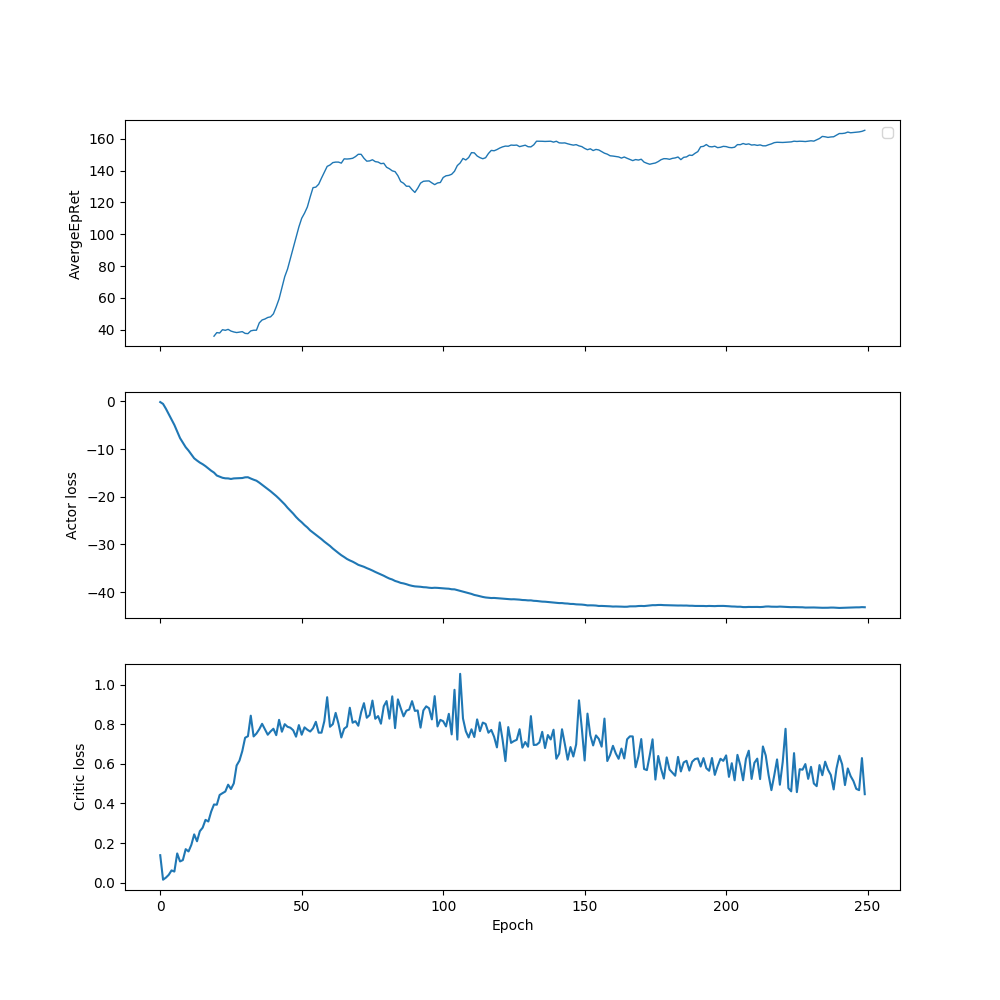

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


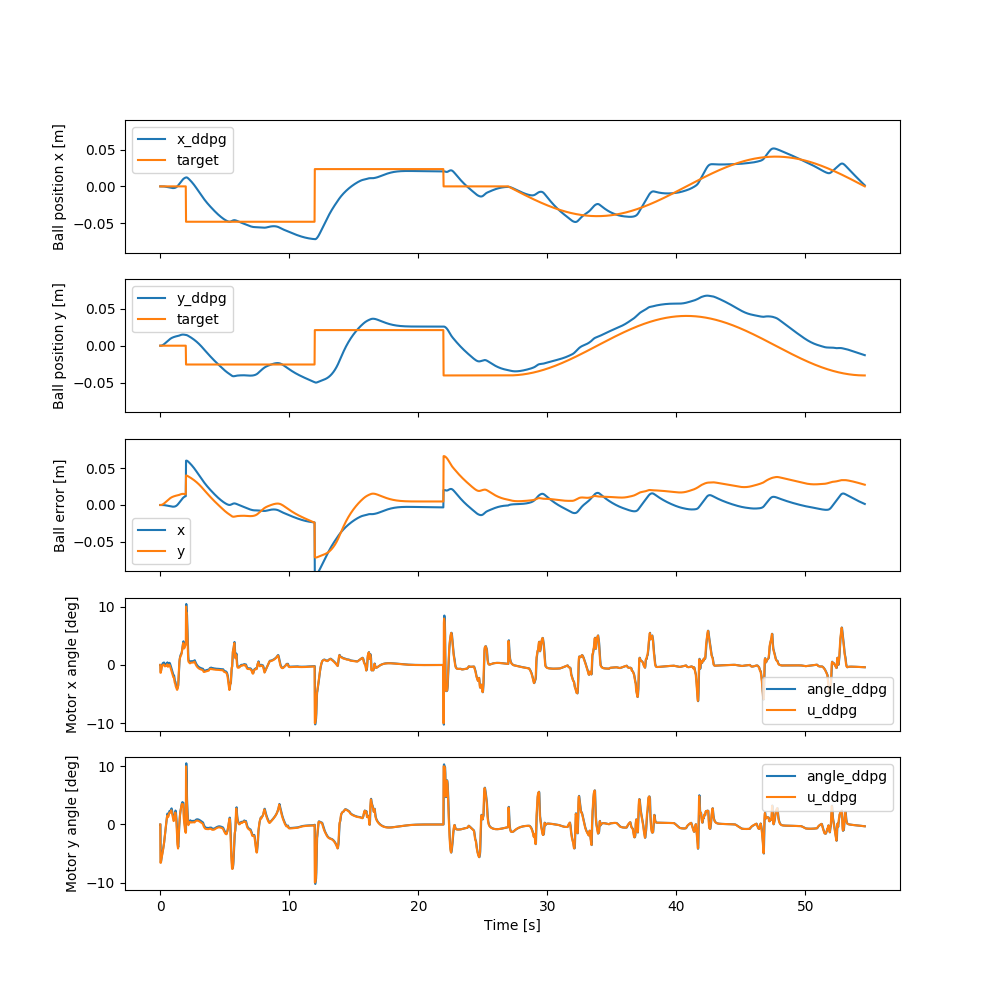

In [12]:
env = BBEnv
ac = BlackBoxActorCritic
reward_fn = linear_de_penality_reward
w = 0.4
hidden_size = [100]
activation = torch.nn.ReLU
name='dep_0.4_[100]_relu_no_bias'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/lep_0.3_[100]_relu_no_bias/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"BlackBoxActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f8cf02214a8>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/lep_0.3_[100]_relu_no_bias",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/lep_0.3_[100]_relu_no_bias/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
           

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |           -57.6 |
|          StdEpRet |            19.7 |
|          MaxEpRet |             -35 |
|          MinEpRet |           -91.5 |
|  AverageTestEpRet |           -24.5 |
|      StdTestEpRet |            11.6 |
|      MaxTestEpRet |           -2.28 |
|      MinTestEpRet |           -42.8 |
|             EpLen |             229 |
|         TestEpLen |             141 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |           -2.88 |
|          StdQVals |            3.84 |
|          MaxQVals |            11.1 |
|          MinQVals |           -15.3 |
|            LossPi |            2.76 |
|             LossQ |           0.119 |
|              Time |            28.3 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |           -1.56 |
|          StdEpRet |              44 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |           -11.9 |
|          StdEpRet |            22.4 |
|          MaxEpRet |            24.4 |
|          MinEpRet |           -36.3 |
|  AverageTestEpRet |           -18.2 |
|      StdTestEpRet |              20 |
|      MaxTestEpRet |            26.7 |
|      MinTestEpRet |           -38.9 |
|             EpLen |             124 |
|         TestEpLen |             138 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |           -4.92 |
|          StdQVals |            8.98 |
|          MaxQVals |            27.8 |
|          MinQVals |           -30.4 |
|            LossPi |             4.8 |
|             LossQ |           0.492 |
|              Time |            77.9 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |            -5.8 |
|          StdEpRet |            13.7 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |           -18.8 |
|          StdEpRet |            8.57 |
|          MaxEpRet |           -11.2 |
|          MinEpRet |             -35 |
|  AverageTestEpRet |           -15.8 |
|      StdTestEpRet |            29.9 |
|      MaxTestEpRet |             101 |
|      MinTestEpRet |           -50.2 |
|             EpLen |             203 |
|         TestEpLen |             180 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |           -3.73 |
|          StdQVals |            11.5 |
|          MaxQVals |            37.5 |
|          MinQVals |           -38.9 |
|            LossPi |            3.61 |
|             LossQ |           0.506 |
|              Time |             129 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |           -16.9 |
|          StdEpRet |            16.5 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |           -8.31 |
|          StdEpRet |            20.3 |
|          MaxEpRet |            24.6 |
|          MinEpRet |           -35.8 |
|  AverageTestEpRet |             -14 |
|      StdTestEpRet |            13.2 |
|      MaxTestEpRet |            8.24 |
|      MinTestEpRet |           -31.3 |
|             EpLen |             143 |
|         TestEpLen |             131 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |          -0.837 |
|          StdQVals |            12.7 |
|          MaxQVals |            40.5 |
|          MinQVals |           -33.7 |
|            LossPi |           0.671 |
|             LossQ |           0.672 |
|              Time |             176 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |          -0.491 |
|          StdEpRet |            40.2 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |           -9.26 |
|          StdEpRet |            33.9 |
|          MaxEpRet |            56.2 |
|          MinEpRet |           -35.8 |
|  AverageTestEpRet |            7.48 |
|      StdTestEpRet |            56.6 |
|      MaxTestEpRet |             117 |
|      MinTestEpRet |           -45.8 |
|             EpLen |             195 |
|         TestEpLen |             230 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |             4.8 |
|          StdQVals |            14.9 |
|          MaxQVals |            39.1 |
|          MinQVals |           -35.4 |
|            LossPi |           -5.02 |
|             LossQ |           0.838 |
|              Time |             227 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |            20.8 |
|          StdEpRet |              35 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |            25.3 |
|          StdEpRet |            56.9 |
|          MaxEpRet |            88.6 |
|          MinEpRet |           -37.5 |
|  AverageTestEpRet |            82.1 |
|      StdTestEpRet |            52.3 |
|      MaxTestEpRet |             156 |
|      MinTestEpRet |           -41.4 |
|             EpLen |             263 |
|         TestEpLen |             368 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            10.7 |
|          StdQVals |            15.4 |
|          MaxQVals |            50.3 |
|          MinQVals |           -69.9 |
|            LossPi |             -11 |
|             LossQ |           0.881 |
|              Time |             283 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             118 |
|          StdEpRet |            1.11 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |            89.1 |
|          StdEpRet |            32.6 |
|          MaxEpRet |             135 |
|          MinEpRet |            65.8 |
|  AverageTestEpRet |             102 |
|      StdTestEpRet |            35.6 |
|      MaxTestEpRet |             176 |
|      MinTestEpRet |            33.3 |
|             EpLen |             400 |
|         TestEpLen |             385 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |              14 |
|          StdQVals |            15.7 |
|          MaxQVals |            43.2 |
|          MinQVals |           -27.6 |
|            LossPi |           -14.3 |
|             LossQ |           0.782 |
|              Time |             344 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             131 |
|          StdEpRet |            12.4 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             118 |
|          StdEpRet |             8.1 |
|          MaxEpRet |             126 |
|          MinEpRet |             107 |
|  AverageTestEpRet |             131 |
|      StdTestEpRet |            48.9 |
|      MaxTestEpRet |             201 |
|      MinTestEpRet |           -33.9 |
|             EpLen |             400 |
|         TestEpLen |             384 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            17.3 |
|          StdQVals |            15.8 |
|          MaxQVals |            47.4 |
|          MinQVals |           -39.3 |
|            LossPi |           -17.5 |
|             LossQ |           0.772 |
|              Time |             401 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             122 |
|          StdEpRet |            34.8 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             113 |
|          StdEpRet |              49 |
|          MaxEpRet |             182 |
|          MinEpRet |            70.9 |
|  AverageTestEpRet |             122 |
|      StdTestEpRet |            46.6 |
|      MaxTestEpRet |             191 |
|      MinTestEpRet |           -13.6 |
|             EpLen |             400 |
|         TestEpLen |             388 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |            20.8 |
|          StdQVals |            16.7 |
|          MaxQVals |            54.7 |
|          MinQVals |           -57.2 |
|            LossPi |             -21 |
|             LossQ |           0.717 |
|              Time |             466 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             111 |
|          StdEpRet |            19.3 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             123 |
|          StdEpRet |            21.1 |
|          MaxEpRet |             152 |
|          MinEpRet |             105 |
|  AverageTestEpRet |             135 |
|      StdTestEpRet |            45.5 |
|      MaxTestEpRet |             181 |
|      MinTestEpRet |           -31.5 |
|             EpLen |             400 |
|         TestEpLen |             383 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |            23.6 |
|          StdQVals |            17.2 |
|          MaxQVals |              55 |
|          MinQVals |           -22.2 |
|            LossPi |           -23.8 |
|             LossQ |            0.67 |
|              Time |             525 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |            97.4 |
|          StdEpRet |            60.4 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |             127 |
|          StdEpRet |            24.6 |
|          MaxEpRet |             152 |
|          MinEpRet |             103 |
|  AverageTestEpRet |             133 |
|      StdTestEpRet |            32.6 |
|      MaxTestEpRet |             212 |
|      MinTestEpRet |            82.1 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            26.1 |
|          StdQVals |            17.4 |
|          MaxQVals |            54.4 |
|          MinQVals |           -33.4 |
|            LossPi |           -26.4 |
|             LossQ |           0.692 |
|              Time |             587 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             120 |
|          StdEpRet |            24.9 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |             115 |
|          StdEpRet |            11.7 |
|          MaxEpRet |             127 |
|          MinEpRet |             103 |
|  AverageTestEpRet |             121 |
|      StdTestEpRet |            36.2 |
|      MaxTestEpRet |             170 |
|      MinTestEpRet |            22.4 |
|             EpLen |             400 |
|         TestEpLen |             391 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |            29.2 |
|          StdQVals |            17.2 |
|          MaxQVals |            54.4 |
|          MinQVals |           -41.4 |
|            LossPi |           -29.4 |
|             LossQ |           0.653 |
|              Time |             647 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             148 |
|          StdEpRet |            40.2 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             123 |
|          StdEpRet |            24.9 |
|          MaxEpRet |             158 |
|          MinEpRet |             101 |
|  AverageTestEpRet |             136 |
|      StdTestEpRet |            47.4 |
|      MaxTestEpRet |             191 |
|      MinTestEpRet |           -48.4 |
|             EpLen |             400 |
|         TestEpLen |             385 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |            31.5 |
|          StdQVals |            17.4 |
|          MaxQVals |            64.5 |
|          MinQVals |             -39 |
|            LossPi |           -31.8 |
|             LossQ |           0.706 |
|              Time |             708 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             146 |
|          StdEpRet |            29.3 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             126 |
|          StdEpRet |            29.3 |
|          MaxEpRet |             167 |
|          MinEpRet |             101 |
|  AverageTestEpRet |             189 |
|      StdTestEpRet |            35.8 |
|      MaxTestEpRet |             263 |
|      MinTestEpRet |             118 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            33.6 |
|          StdQVals |            17.3 |
|          MaxQVals |            58.3 |
|          MinQVals |           -40.4 |
|            LossPi |           -33.8 |
|             LossQ |           0.722 |
|              Time |             770 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             167 |
|          StdEpRet |            33.4 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             124 |
|          StdEpRet |            9.08 |
|          MaxEpRet |             133 |
|          MinEpRet |             115 |
|  AverageTestEpRet |             143 |
|      StdTestEpRet |              23 |
|      MaxTestEpRet |             207 |
|      MinTestEpRet |             105 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            35.7 |
|          StdQVals |            17.5 |
|          MaxQVals |              80 |
|          MinQVals |             -54 |
|            LossPi |           -35.9 |
|             LossQ |           0.729 |
|              Time |             830 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             118 |
|          StdEpRet |             5.2 |


---------------------------------------
|             Epoch |             157 |
|      AverageEpRet |             114 |
|          StdEpRet |            85.4 |
|          MaxEpRet |             175 |
|          MinEpRet |           -32.9 |
|  AverageTestEpRet |             145 |
|      StdTestEpRet |            39.5 |
|      MaxTestEpRet |             240 |
|      MinTestEpRet |            99.7 |
|             EpLen |             318 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.73e+05 |
|      AverageQVals |            38.4 |
|          StdQVals |            17.7 |
|          MaxQVals |              62 |
|          MinQVals |           -40.6 |
|            LossPi |           -38.6 |
|             LossQ |           0.621 |
|              Time |             894 |
---------------------------------------
---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             141 |
|          StdEpRet |            18.8 |


---------------------------------------
|             Epoch |             167 |
|      AverageEpRet |             160 |
|          StdEpRet |            7.87 |
|          MaxEpRet |             168 |
|          MinEpRet |             152 |
|  AverageTestEpRet |             114 |
|      StdTestEpRet |            40.9 |
|      MaxTestEpRet |             211 |
|      MinTestEpRet |            66.2 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.84e+05 |
|      AverageQVals |            40.1 |
|          StdQVals |            17.6 |
|          MaxQVals |            63.7 |
|          MinQVals |           -43.3 |
|            LossPi |           -40.4 |
|             LossQ |           0.644 |
|              Time |             958 |
---------------------------------------
---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             106 |
|          StdEpRet |            20.1 |


---------------------------------------
|             Epoch |             177 |
|      AverageEpRet |             141 |
|          StdEpRet |            35.2 |
|          MaxEpRet |             173 |
|          MinEpRet |            92.2 |
|  AverageTestEpRet |             149 |
|      StdTestEpRet |            26.2 |
|      MaxTestEpRet |             186 |
|      MinTestEpRet |            88.5 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.95e+05 |
|      AverageQVals |            41.9 |
|          StdQVals |            17.4 |
|          MaxQVals |            68.2 |
|          MinQVals |           -55.9 |
|            LossPi |           -42.2 |
|             LossQ |           0.644 |
|              Time |        1.02e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             138 |
|          StdEpRet |            24.9 |


---------------------------------------
|             Epoch |             187 |
|      AverageEpRet |             124 |
|          StdEpRet |            12.5 |
|          MaxEpRet |             140 |
|          MinEpRet |             109 |
|  AverageTestEpRet |             118 |
|      StdTestEpRet |            65.1 |
|      MaxTestEpRet |             194 |
|      MinTestEpRet |           -32.9 |
|             EpLen |             400 |
|         TestEpLen |             357 |
| TotalEnvInteracts |        2.06e+05 |
|      AverageQVals |            43.5 |
|          StdQVals |            17.4 |
|          MaxQVals |            66.8 |
|          MinQVals |           -40.2 |
|            LossPi |           -43.8 |
|             LossQ |           0.639 |
|              Time |        1.08e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             117 |
|          StdEpRet |            11.8 |


---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |             151 |
|          StdEpRet |            37.2 |
|          MaxEpRet |             198 |
|          MinEpRet |             107 |
|  AverageTestEpRet |             150 |
|      StdTestEpRet |            65.4 |
|      MaxTestEpRet |             210 |
|      MinTestEpRet |           -37.3 |
|             EpLen |             400 |
|         TestEpLen |             368 |
| TotalEnvInteracts |        2.17e+05 |
|      AverageQVals |              44 |
|          StdQVals |            17.3 |
|          MaxQVals |            76.4 |
|          MinQVals |           -43.7 |
|            LossPi |           -44.2 |
|             LossQ |           0.718 |
|              Time |        1.14e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             182 |
|          StdEpRet |            41.1 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |             182 |
|          StdEpRet |            49.1 |
|          MaxEpRet |             246 |
|          MinEpRet |             126 |
|  AverageTestEpRet |             188 |
|      StdTestEpRet |            45.1 |
|      MaxTestEpRet |             262 |
|      MinTestEpRet |            97.8 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.28e+05 |
|      AverageQVals |            45.1 |
|          StdQVals |            17.3 |
|          MaxQVals |            68.9 |
|          MinQVals |           -25.9 |
|            LossPi |           -45.3 |
|             LossQ |           0.614 |
|              Time |         1.2e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |             182 |
|          StdEpRet |             1.7 |


---------------------------------------
|             Epoch |             217 |
|      AverageEpRet |             116 |
|          StdEpRet |            92.4 |
|          MaxEpRet |             204 |
|          MinEpRet |           -11.3 |
|  AverageTestEpRet |             164 |
|      StdTestEpRet |              65 |
|      MaxTestEpRet |             237 |
|      MinTestEpRet |           -84.3 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.39e+05 |
|      AverageQVals |            46.6 |
|          StdQVals |            17.7 |
|          MaxQVals |            72.2 |
|          MinQVals |           -37.2 |
|            LossPi |           -46.8 |
|             LossQ |            0.66 |
|              Time |        1.27e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |             156 |
|          StdEpRet |            17.4 |


---------------------------------------
|             Epoch |             227 |
|      AverageEpRet |             162 |
|          StdEpRet |            6.43 |
|          MaxEpRet |             170 |
|          MinEpRet |             155 |
|  AverageTestEpRet |             132 |
|      StdTestEpRet |            69.3 |
|      MaxTestEpRet |             219 |
|      MinTestEpRet |           -4.46 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.5e+05 |
|      AverageQVals |            47.7 |
|          StdQVals |            17.7 |
|          MaxQVals |            73.3 |
|          MinQVals |           -33.4 |
|            LossPi |           -47.9 |
|             LossQ |           0.569 |
|              Time |        1.33e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             228 |
|      AverageEpRet |             145 |
|          StdEpRet |            11.8 |


---------------------------------------
|             Epoch |             237 |
|      AverageEpRet |             144 |
|          StdEpRet |            34.5 |
|          MaxEpRet |             191 |
|          MinEpRet |             108 |
|  AverageTestEpRet |             165 |
|      StdTestEpRet |            33.1 |
|      MaxTestEpRet |             228 |
|      MinTestEpRet |             104 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.61e+05 |
|      AverageQVals |            47.8 |
|          StdQVals |            17.5 |
|          MaxQVals |              83 |
|          MinQVals |           -38.8 |
|            LossPi |             -48 |
|             LossQ |           0.729 |
|              Time |        1.39e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             238 |
|      AverageEpRet |             222 |
|          StdEpRet |            16.6 |


---------------------------------------
|             Epoch |             247 |
|      AverageEpRet |             156 |
|          StdEpRet |            5.57 |
|          MaxEpRet |             161 |
|          MinEpRet |             148 |
|  AverageTestEpRet |             122 |
|      StdTestEpRet |            85.5 |
|      MaxTestEpRet |             241 |
|      MinTestEpRet |           -37.8 |
|             EpLen |             400 |
|         TestEpLen |             351 |
| TotalEnvInteracts |        2.72e+05 |
|      AverageQVals |            48.6 |
|          StdQVals |            17.8 |
|          MaxQVals |            74.2 |
|          MinQVals |           -55.2 |
|            LossPi |           -48.9 |
|             LossQ |           0.627 |
|              Time |        1.45e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             248 |
|      AverageEpRet |             132 |
|          StdEpRet |              20 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.00033371304860968666


<IPython.core.display.Javascript object>


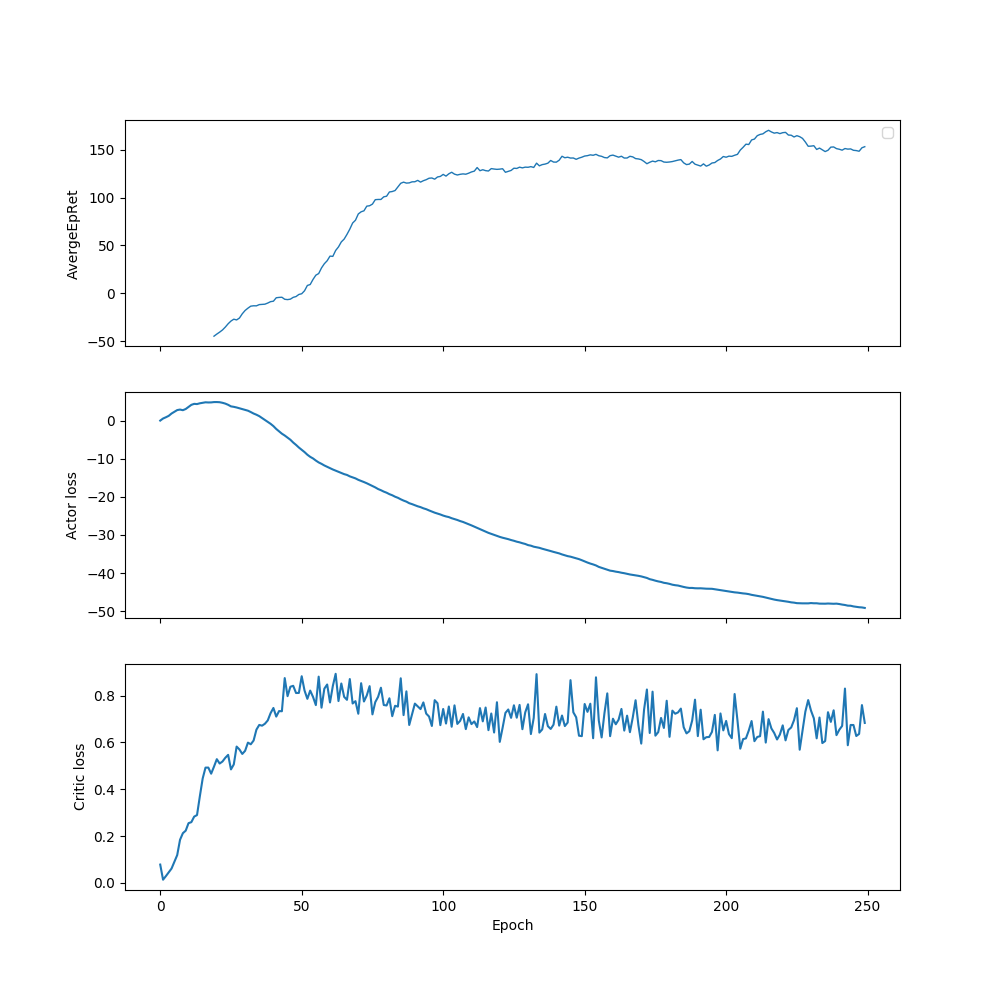

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


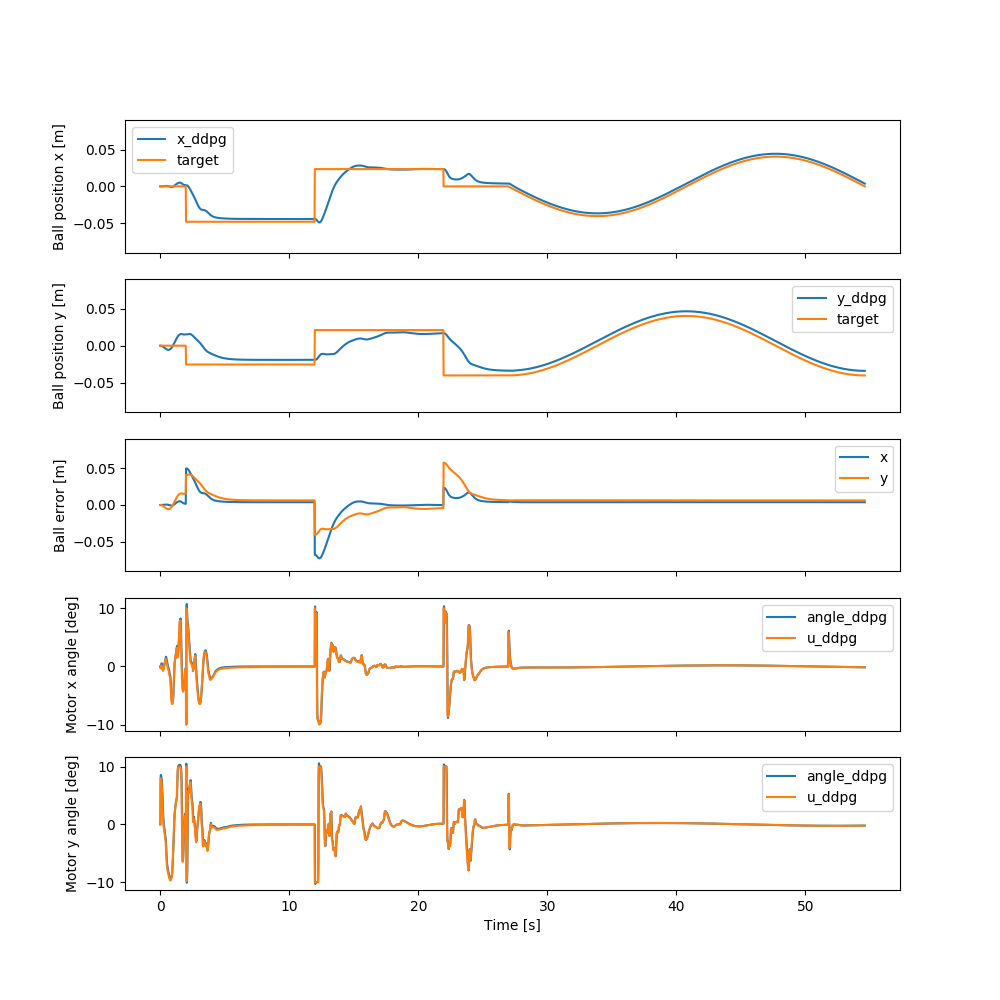

In [14]:
env = BBEnv
ac = BlackBoxActorCritic
reward_fn = linear_e_reward_penality
w = 0.3
hidden_size = [100]
activation = torch.nn.ReLU
name='lep_0.3_[100]_relu_no_bias'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/lep_0.3_[100]_sigmoid_no_bias/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"Sigmoid",
        "hidden_sizes":	[
            100
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"BlackBoxActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f825e9af518>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/lep_0.3_[100]_sigmoid_no_bias",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/lep_0.3_[100]_sigmoid_no_bias/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |           -69.9 |
|          StdEpRet |            59.3 |
|          MaxEpRet |           -9.09 |
|          MinEpRet |            -150 |
|  AverageTestEpRet |            -5.5 |
|      StdTestEpRet |            35.4 |
|      MaxTestEpRet |              69 |
|      MinTestEpRet |           -61.6 |
|             EpLen |             365 |
|         TestEpLen |             252 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |           -2.41 |
|          StdQVals |            4.13 |
|          MaxQVals |            11.8 |
|          MinQVals |           -7.73 |
|            LossPi |            2.27 |
|             LossQ |          0.0737 |
|              Time |            37.6 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |           -68.1 |
|          StdEpRet |            50.2 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |           0.521 |
|          StdEpRet |            34.5 |
|          MaxEpRet |              49 |
|          MinEpRet |           -44.1 |
|  AverageTestEpRet |           -12.3 |
|      StdTestEpRet |            21.3 |
|      MaxTestEpRet |            41.9 |
|      MinTestEpRet |             -36 |
|             EpLen |             207 |
|         TestEpLen |             192 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |           -2.88 |
|          StdQVals |            8.71 |
|          MaxQVals |            27.5 |
|          MinQVals |           -13.6 |
|            LossPi |            2.74 |
|             LossQ |           0.243 |
|              Time |             102 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |           -29.5 |
|          StdEpRet |            9.95 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |           -18.9 |
|          StdEpRet |            27.6 |
|          MaxEpRet |            24.5 |
|          MinEpRet |           -60.9 |
|  AverageTestEpRet |           -10.4 |
|      StdTestEpRet |            25.4 |
|      MaxTestEpRet |            39.7 |
|      MinTestEpRet |             -50 |
|             EpLen |             180 |
|         TestEpLen |             186 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |           -2.12 |
|          StdQVals |            11.2 |
|          MaxQVals |            35.3 |
|          MinQVals |           -15.8 |
|            LossPi |            2.01 |
|             LossQ |           0.402 |
|              Time |             164 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |           -20.7 |
|          StdEpRet |            24.2 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |           -16.8 |
|          StdEpRet |            21.6 |
|          MaxEpRet |              13 |
|          MinEpRet |           -39.5 |
|  AverageTestEpRet |           -11.2 |
|      StdTestEpRet |            23.2 |
|      MaxTestEpRet |            29.8 |
|      MinTestEpRet |             -44 |
|             EpLen |             174 |
|         TestEpLen |             223 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |           -2.13 |
|          StdQVals |            11.6 |
|          MaxQVals |            40.5 |
|          MinQVals |           -18.2 |
|            LossPi |            2.03 |
|             LossQ |           0.501 |
|              Time |             228 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |           -9.89 |
|          StdEpRet |              29 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |              90 |
|          StdEpRet |            67.6 |
|          MaxEpRet |             171 |
|          MinEpRet |            5.68 |
|  AverageTestEpRet |              42 |
|      StdTestEpRet |            75.5 |
|      MaxTestEpRet |             204 |
|      MinTestEpRet |           -40.9 |
|             EpLen |             368 |
|         TestEpLen |             286 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |          -0.945 |
|          StdQVals |            12.2 |
|          MaxQVals |            43.4 |
|          MinQVals |           -20.3 |
|            LossPi |            0.84 |
|             LossQ |           0.462 |
|              Time |             293 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |              18 |
|          StdEpRet |            63.9 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |            17.3 |
|          StdEpRet |             106 |
|          MaxEpRet |             199 |
|          MinEpRet |           -71.6 |
|  AverageTestEpRet |            92.2 |
|      StdTestEpRet |            98.4 |
|      MaxTestEpRet |             221 |
|      MinTestEpRet |           -74.4 |
|             EpLen |             331 |
|         TestEpLen |             347 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            2.92 |
|          StdQVals |            15.5 |
|          MaxQVals |            46.2 |
|          MinQVals |           -24.1 |
|            LossPi |           -3.06 |
|             LossQ |           0.453 |
|              Time |             364 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |            99.6 |
|          StdEpRet |            77.6 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |            84.2 |
|          StdEpRet |            82.6 |
|          MaxEpRet |             185 |
|          MinEpRet |            1.99 |
|  AverageTestEpRet |            88.9 |
|      StdTestEpRet |            82.4 |
|      MaxTestEpRet |             253 |
|      MinTestEpRet |           -43.5 |
|             EpLen |             316 |
|         TestEpLen |             347 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |            9.99 |
|          StdQVals |            20.3 |
|          MaxQVals |            54.5 |
|          MinQVals |           -22.1 |
|            LossPi |           -10.2 |
|             LossQ |           0.544 |
|              Time |             433 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |            17.1 |
|          StdEpRet |            52.7 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             185 |
|          StdEpRet |            48.1 |
|          MaxEpRet |             229 |
|          MinEpRet |             118 |
|  AverageTestEpRet |             149 |
|      StdTestEpRet |             104 |
|      MaxTestEpRet |             263 |
|      MinTestEpRet |           -57.5 |
|             EpLen |             400 |
|         TestEpLen |             358 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            18.1 |
|          StdQVals |            24.2 |
|          MaxQVals |            61.6 |
|          MinQVals |           -19.3 |
|            LossPi |           -18.3 |
|             LossQ |           0.606 |
|              Time |             506 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |            84.2 |
|          StdEpRet |              84 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             184 |
|          StdEpRet |            8.83 |
|          MaxEpRet |             194 |
|          MinEpRet |             173 |
|  AverageTestEpRet |             214 |
|      StdTestEpRet |              42 |
|      MaxTestEpRet |             285 |
|      MinTestEpRet |             120 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |              26 |
|          StdQVals |            27.1 |
|          MaxQVals |            70.9 |
|          MinQVals |           -20.3 |
|            LossPi |           -26.2 |
|             LossQ |           0.597 |
|              Time |             579 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             137 |
|          StdEpRet |            7.32 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             127 |
|          StdEpRet |            15.4 |
|          MaxEpRet |             143 |
|          MinEpRet |             106 |
|  AverageTestEpRet |             175 |
|      StdTestEpRet |              72 |
|      MaxTestEpRet |             276 |
|      MinTestEpRet |           -45.7 |
|             EpLen |             400 |
|         TestEpLen |             388 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |            32.8 |
|          StdQVals |            28.8 |
|          MaxQVals |            77.7 |
|          MinQVals |           -22.4 |
|            LossPi |           -33.1 |
|             LossQ |           0.646 |
|              Time |             660 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             185 |
|          StdEpRet |            27.6 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |              67 |
|          StdEpRet |            28.8 |
|          MaxEpRet |             101 |
|          MinEpRet |            30.3 |
|  AverageTestEpRet |             161 |
|      StdTestEpRet |            49.4 |
|      MaxTestEpRet |             269 |
|      MinTestEpRet |            39.5 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            37.6 |
|          StdQVals |            29.3 |
|          MaxQVals |            79.3 |
|          MinQVals |           -22.7 |
|            LossPi |           -37.9 |
|             LossQ |           0.646 |
|              Time |             741 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             203 |
|          StdEpRet |            2.02 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |              95 |
|          StdEpRet |             106 |
|          MaxEpRet |             180 |
|          MinEpRet |           -54.6 |
|  AverageTestEpRet |             149 |
|      StdTestEpRet |            77.6 |
|      MaxTestEpRet |             238 |
|      MinTestEpRet |           -33.6 |
|             EpLen |             331 |
|         TestEpLen |             386 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |            42.7 |
|          StdQVals |            29.4 |
|          MaxQVals |            82.6 |
|          MinQVals |           -22.5 |
|            LossPi |             -43 |
|             LossQ |           0.643 |
|              Time |             822 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             148 |
|          StdEpRet |            18.5 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             101 |
|          StdEpRet |            21.9 |
|          MaxEpRet |             129 |
|          MinEpRet |            76.4 |
|  AverageTestEpRet |             108 |
|      StdTestEpRet |            77.3 |
|      MaxTestEpRet |             178 |
|      MinTestEpRet |            -108 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |            47.6 |
|          StdQVals |              27 |
|          MaxQVals |            87.9 |
|          MinQVals |           -21.2 |
|            LossPi |             -48 |
|             LossQ |            0.72 |
|              Time |             900 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             166 |
|          StdEpRet |            19.6 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             176 |
|          StdEpRet |            4.45 |
|          MaxEpRet |             180 |
|          MinEpRet |             171 |
|  AverageTestEpRet |             126 |
|      StdTestEpRet |            56.4 |
|      MaxTestEpRet |             224 |
|      MinTestEpRet |            10.4 |
|             EpLen |             400 |
|         TestEpLen |             394 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            51.1 |
|          StdQVals |            26.6 |
|          MaxQVals |            89.6 |
|          MinQVals |           -17.5 |
|            LossPi |           -51.4 |
|             LossQ |           0.681 |
|              Time |             986 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             145 |
|          StdEpRet |            55.3 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             102 |
|          StdEpRet |            55.6 |
|          MaxEpRet |             166 |
|          MinEpRet |            30.4 |
|  AverageTestEpRet |            92.5 |
|      StdTestEpRet |            68.1 |
|      MaxTestEpRet |             209 |
|      MinTestEpRet |             -65 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            53.4 |
|          StdQVals |            26.2 |
|          MaxQVals |            92.8 |
|          MinQVals |           -21.7 |
|            LossPi |           -53.7 |
|             LossQ |           0.699 |
|              Time |        1.06e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |            72.6 |
|          StdEpRet |            12.7 |


---------------------------------------
|             Epoch |             157 |
|      AverageEpRet |             160 |
|          StdEpRet |            30.8 |
|          MaxEpRet |             203 |
|          MinEpRet |             130 |
|  AverageTestEpRet |             101 |
|      StdTestEpRet |            61.7 |
|      MaxTestEpRet |             182 |
|      MinTestEpRet |           -82.1 |
|             EpLen |             400 |
|         TestEpLen |             390 |
| TotalEnvInteracts |        1.73e+05 |
|      AverageQVals |            53.7 |
|          StdQVals |            25.1 |
|          MaxQVals |            86.4 |
|          MinQVals |           -22.8 |
|            LossPi |             -54 |
|             LossQ |           0.647 |
|              Time |        1.15e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             118 |
|          StdEpRet |              38 |


---------------------------------------
|             Epoch |             167 |
|      AverageEpRet |             109 |
|          StdEpRet |            9.04 |
|          MaxEpRet |             120 |
|          MinEpRet |            98.4 |
|  AverageTestEpRet |            91.1 |
|      StdTestEpRet |            26.4 |
|      MaxTestEpRet |             140 |
|      MinTestEpRet |            42.5 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.84e+05 |
|      AverageQVals |            52.6 |
|          StdQVals |            24.4 |
|          MaxQVals |            83.4 |
|          MinQVals |           -25.8 |
|            LossPi |           -52.9 |
|             LossQ |           0.586 |
|              Time |        1.22e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |            91.2 |
|          StdEpRet |            34.5 |


---------------------------------------
|             Epoch |             177 |
|      AverageEpRet |            71.6 |
|          StdEpRet |            61.4 |
|          MaxEpRet |             121 |
|          MinEpRet |           -30.9 |
|  AverageTestEpRet |             103 |
|      StdTestEpRet |            35.6 |
|      MaxTestEpRet |             161 |
|      MinTestEpRet |           -17.9 |
|             EpLen |             332 |
|         TestEpLen |             384 |
| TotalEnvInteracts |        1.95e+05 |
|      AverageQVals |            53.3 |
|          StdQVals |            24.2 |
|          MaxQVals |            81.4 |
|          MinQVals |           -20.7 |
|            LossPi |           -53.6 |
|             LossQ |           0.567 |
|              Time |         1.3e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             128 |
|          StdEpRet |            16.5 |


---------------------------------------
|             Epoch |             187 |
|      AverageEpRet |             122 |
|          StdEpRet |            40.7 |
|          MaxEpRet |             157 |
|          MinEpRet |            64.8 |
|  AverageTestEpRet |             115 |
|      StdTestEpRet |            48.6 |
|      MaxTestEpRet |             178 |
|      MinTestEpRet |           -36.3 |
|             EpLen |             400 |
|         TestEpLen |             385 |
| TotalEnvInteracts |        2.06e+05 |
|      AverageQVals |              53 |
|          StdQVals |            24.1 |
|          MaxQVals |            79.4 |
|          MinQVals |           -20.9 |
|            LossPi |           -53.3 |
|             LossQ |           0.504 |
|              Time |        1.38e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |              93 |
|          StdEpRet |            60.9 |


---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |             111 |
|          StdEpRet |            51.3 |
|          MaxEpRet |             166 |
|          MinEpRet |            42.3 |
|  AverageTestEpRet |            92.5 |
|      StdTestEpRet |            53.5 |
|      MaxTestEpRet |             168 |
|      MinTestEpRet |           -50.7 |
|             EpLen |             400 |
|         TestEpLen |             387 |
| TotalEnvInteracts |        2.17e+05 |
|      AverageQVals |            52.7 |
|          StdQVals |            23.8 |
|          MaxQVals |            78.6 |
|          MinQVals |           -20.5 |
|            LossPi |           -52.9 |
|             LossQ |           0.543 |
|              Time |        1.46e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |            99.8 |
|          StdEpRet |            50.2 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |             104 |
|          StdEpRet |            2.96 |
|          MaxEpRet |             107 |
|          MinEpRet |             101 |
|  AverageTestEpRet |             114 |
|      StdTestEpRet |            55.9 |
|      MaxTestEpRet |             196 |
|      MinTestEpRet |           -41.6 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.28e+05 |
|      AverageQVals |            51.4 |
|          StdQVals |            22.6 |
|          MaxQVals |            80.1 |
|          MinQVals |           -18.9 |
|            LossPi |           -51.6 |
|             LossQ |           0.555 |
|              Time |        1.54e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |            34.3 |
|          StdEpRet |            52.7 |


---------------------------------------
|             Epoch |             217 |
|      AverageEpRet |            90.5 |
|          StdEpRet |            28.7 |
|          MaxEpRet |             130 |
|          MinEpRet |            62.5 |
|  AverageTestEpRet |             103 |
|      StdTestEpRet |            47.3 |
|      MaxTestEpRet |             166 |
|      MinTestEpRet |           -43.4 |
|             EpLen |             400 |
|         TestEpLen |             384 |
| TotalEnvInteracts |        2.39e+05 |
|      AverageQVals |            51.5 |
|          StdQVals |            21.9 |
|          MaxQVals |            77.9 |
|          MinQVals |             -30 |
|            LossPi |           -51.8 |
|             LossQ |           0.603 |
|              Time |        1.61e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |            99.2 |
|          StdEpRet |            14.8 |


---------------------------------------
|             Epoch |             227 |
|      AverageEpRet |              96 |
|          StdEpRet |            45.1 |
|          MaxEpRet |             141 |
|          MinEpRet |            50.9 |
|  AverageTestEpRet |             134 |
|      StdTestEpRet |            51.3 |
|      MaxTestEpRet |             216 |
|      MinTestEpRet |           -13.9 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.5e+05 |
|      AverageQVals |            51.5 |
|          StdQVals |            21.4 |
|          MaxQVals |            75.3 |
|          MinQVals |           -26.8 |
|            LossPi |           -51.8 |
|             LossQ |           0.572 |
|              Time |        1.69e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             228 |
|      AverageEpRet |             152 |
|          StdEpRet |            34.5 |


---------------------------------------
|             Epoch |             237 |
|      AverageEpRet |            73.1 |
|          StdEpRet |            31.2 |
|          MaxEpRet |            97.7 |
|          MinEpRet |              29 |
|  AverageTestEpRet |            54.2 |
|      StdTestEpRet |              44 |
|      MaxTestEpRet |             119 |
|      MinTestEpRet |           -24.8 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.61e+05 |
|      AverageQVals |            51.9 |
|          StdQVals |            21.4 |
|          MaxQVals |            79.8 |
|          MinQVals |           -24.5 |
|            LossPi |           -52.2 |
|             LossQ |           0.545 |
|              Time |        1.77e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             238 |
|      AverageEpRet |            67.7 |
|          StdEpRet |            23.7 |


---------------------------------------
|             Epoch |             247 |
|      AverageEpRet |            98.1 |
|          StdEpRet |           0.942 |
|          MaxEpRet |              99 |
|          MinEpRet |            97.1 |
|  AverageTestEpRet |            50.6 |
|      StdTestEpRet |            73.4 |
|      MaxTestEpRet |             138 |
|      MinTestEpRet |            -153 |
|             EpLen |             400 |
|         TestEpLen |             354 |
| TotalEnvInteracts |        2.72e+05 |
|      AverageQVals |            51.5 |
|          StdQVals |            21.6 |
|          MaxQVals |            80.5 |
|          MinQVals |           -27.5 |
|            LossPi |           -51.8 |
|             LossQ |            0.53 |
|              Time |        1.84e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             248 |
|      AverageEpRet |            87.4 |
|          StdEpRet |            18.4 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.0004240687822740562


<IPython.core.display.Javascript object>


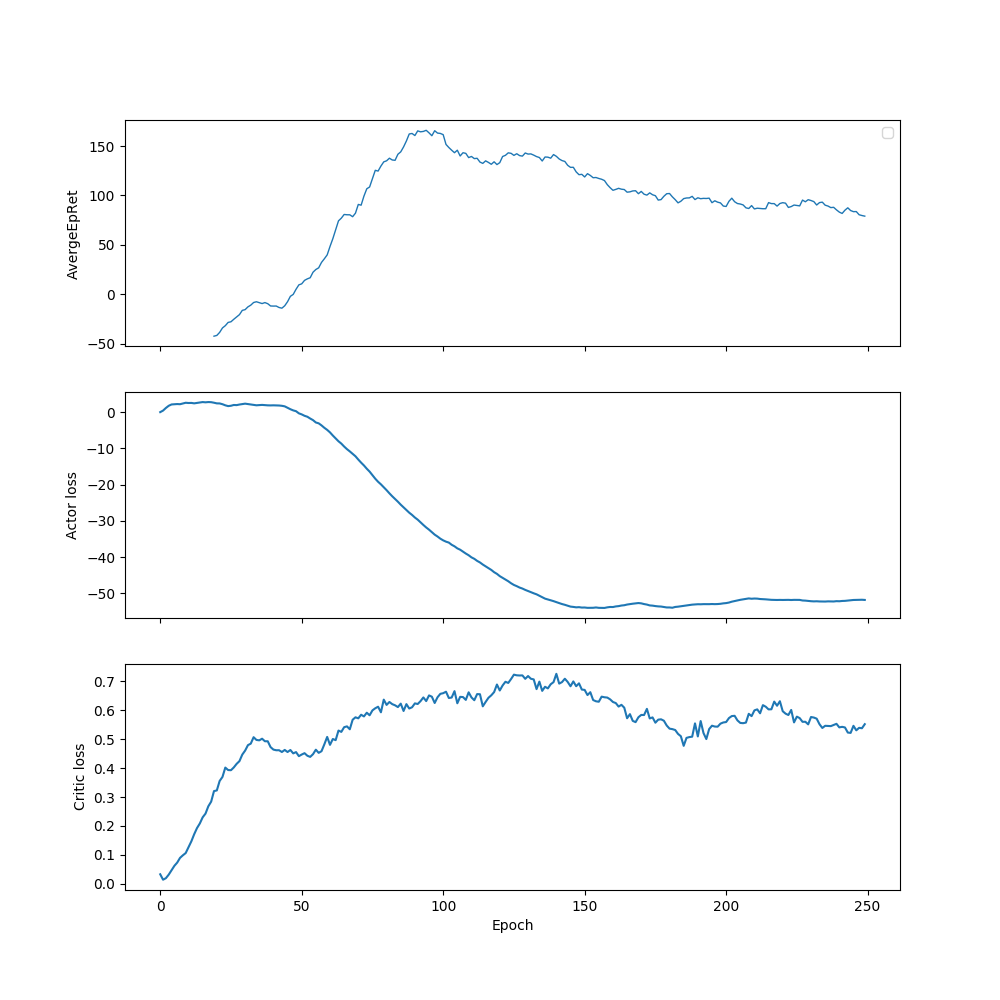

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


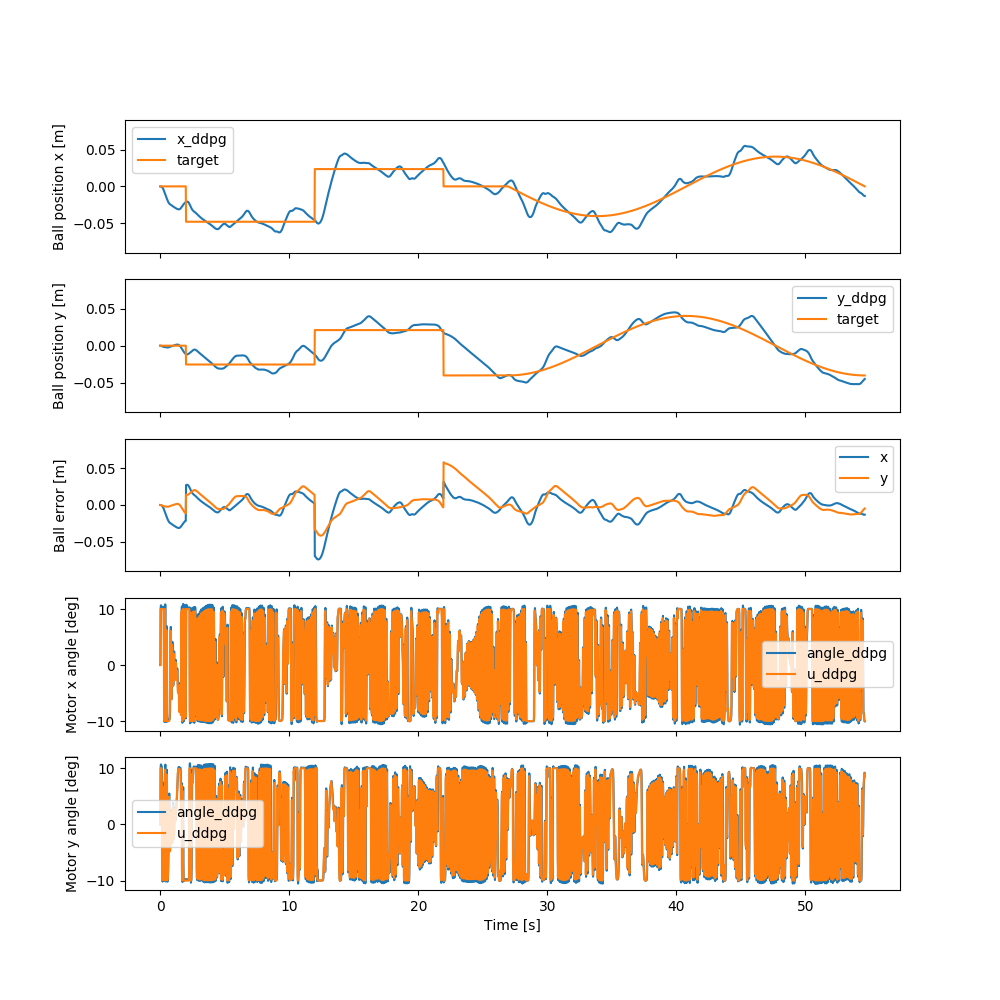

In [13]:
env = BBEnv
ac = BlackBoxActorCritic
reward_fn = linear_e_reward_penality
w = 0.3
hidden_size = [100]
activation = torch.nn.Sigmoid
name='lep_0.3_[100]_sigmoid_no_bias'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnv
ac = BlackBoxActorCritic
reward_fn = linear_de_penality_reward
w = 0.3
hidden_size = [100]
activation = torch.nn.ReLU
name='dep_0.3_[100]_relu_no_bias'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

Logging data to src/data/black_box_controller/exploratory_penality/pep_0.6_[100, 50]_relu/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            100,
            50
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	500,
    "env_fn":	"create_env",
    "epochs":	250,
    "exp_name":	"test",
    "gamma":	0.99,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f8cf24d3710>":	{
            "epoch_dict":	{},
            "exp_name":	"test",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"src/data/black_box_controller/exploratory_penality/pep_0.6_[100, 50]_relu",
            "output_file":	{
                "<_io.TextIOWrapper name='src/data/black_box_controller/exploratory_penality/pep_0.6_[100, 50]_relu/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
            

---------------------------------------
|             Epoch |               7 |
|      AverageEpRet |            73.8 |
|          StdEpRet |            90.3 |
|          MaxEpRet |             195 |
|          MinEpRet |             -22 |
|  AverageTestEpRet |             134 |
|      StdTestEpRet |              76 |
|      MaxTestEpRet |             313 |
|      MinTestEpRet |           -1.37 |
|             EpLen |             333 |
|         TestEpLen |             261 |
| TotalEnvInteracts |         7.7e+03 |
|      AverageQVals |            11.6 |
|          StdQVals |            7.19 |
|          MaxQVals |            30.8 |
|          MinQVals |           -2.97 |
|            LossPi |           -11.8 |
|             LossQ |          0.0953 |
|              Time |            42.8 |
---------------------------------------
---------------------------------------
|             Epoch |               8 |
|      AverageEpRet |            70.2 |
|          StdEpRet |            62.8 |


---------------------------------------
|             Epoch |              17 |
|      AverageEpRet |             105 |
|          StdEpRet |            32.3 |
|          MaxEpRet |             153 |
|          MinEpRet |            62.7 |
|  AverageTestEpRet |             120 |
|      StdTestEpRet |              62 |
|      MaxTestEpRet |             290 |
|      MinTestEpRet |            32.8 |
|             EpLen |             256 |
|         TestEpLen |             262 |
| TotalEnvInteracts |        1.87e+04 |
|      AverageQVals |            25.7 |
|          StdQVals |            16.8 |
|          MaxQVals |            76.9 |
|          MinQVals |           -22.3 |
|            LossPi |           -25.9 |
|             LossQ |           0.392 |
|              Time |             120 |
---------------------------------------
---------------------------------------
|             Epoch |              18 |
|      AverageEpRet |            70.6 |
|          StdEpRet |            49.3 |


---------------------------------------
|             Epoch |              27 |
|      AverageEpRet |             121 |
|          StdEpRet |            26.5 |
|          MaxEpRet |             152 |
|          MinEpRet |            74.1 |
|  AverageTestEpRet |             181 |
|      StdTestEpRet |            72.2 |
|      MaxTestEpRet |             305 |
|      MinTestEpRet |            31.4 |
|             EpLen |             273 |
|         TestEpLen |             334 |
| TotalEnvInteracts |        2.97e+04 |
|      AverageQVals |            29.1 |
|          StdQVals |            21.9 |
|          MaxQVals |              80 |
|          MinQVals |           -22.5 |
|            LossPi |           -29.3 |
|             LossQ |           0.577 |
|              Time |             198 |
---------------------------------------
---------------------------------------
|             Epoch |              28 |
|      AverageEpRet |             211 |
|          StdEpRet |              39 |


---------------------------------------
|             Epoch |              37 |
|      AverageEpRet |             144 |
|          StdEpRet |            86.7 |
|          MaxEpRet |             272 |
|          MinEpRet |            40.3 |
|  AverageTestEpRet |             182 |
|      StdTestEpRet |             100 |
|      MaxTestEpRet |             314 |
|      MinTestEpRet |           -13.1 |
|             EpLen |             269 |
|         TestEpLen |             299 |
| TotalEnvInteracts |        4.07e+04 |
|      AverageQVals |            33.8 |
|          StdQVals |            24.9 |
|          MaxQVals |            83.6 |
|          MinQVals |           -46.5 |
|            LossPi |           -33.9 |
|             LossQ |           0.808 |
|              Time |             278 |
---------------------------------------
---------------------------------------
|             Epoch |              38 |
|      AverageEpRet |             159 |
|          StdEpRet |             115 |


---------------------------------------
|             Epoch |              47 |
|      AverageEpRet |             294 |
|          StdEpRet |            10.9 |
|          MaxEpRet |             306 |
|          MinEpRet |             280 |
|  AverageTestEpRet |             175 |
|      StdTestEpRet |             108 |
|      MaxTestEpRet |             316 |
|      MinTestEpRet |           -0.92 |
|             EpLen |             400 |
|         TestEpLen |             302 |
| TotalEnvInteracts |        5.17e+04 |
|      AverageQVals |            41.5 |
|          StdQVals |            27.6 |
|          MaxQVals |            97.1 |
|          MinQVals |           -8.58 |
|            LossPi |           -41.7 |
|             LossQ |           0.984 |
|              Time |             363 |
---------------------------------------
---------------------------------------
|             Epoch |              48 |
|      AverageEpRet |             191 |
|          StdEpRet |             106 |


---------------------------------------
|             Epoch |              57 |
|      AverageEpRet |             258 |
|          StdEpRet |            9.49 |
|          MaxEpRet |             269 |
|          MinEpRet |             246 |
|  AverageTestEpRet |             266 |
|      StdTestEpRet |            16.8 |
|      MaxTestEpRet |             309 |
|      MinTestEpRet |             233 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        6.27e+04 |
|      AverageQVals |            49.7 |
|          StdQVals |            29.4 |
|          MaxQVals |             107 |
|          MinQVals |           -19.9 |
|            LossPi |           -49.9 |
|             LossQ |            1.05 |
|              Time |             448 |
---------------------------------------
---------------------------------------
|             Epoch |              58 |
|      AverageEpRet |             287 |
|          StdEpRet |            28.9 |


---------------------------------------
|             Epoch |              67 |
|      AverageEpRet |             264 |
|          StdEpRet |            2.41 |
|          MaxEpRet |             267 |
|          MinEpRet |             262 |
|  AverageTestEpRet |             284 |
|      StdTestEpRet |            22.7 |
|      MaxTestEpRet |             334 |
|      MinTestEpRet |             249 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        7.37e+04 |
|      AverageQVals |            56.5 |
|          StdQVals |            29.2 |
|          MaxQVals |             101 |
|          MinQVals |           -26.7 |
|            LossPi |           -56.7 |
|             LossQ |            1.03 |
|              Time |             536 |
---------------------------------------
---------------------------------------
|             Epoch |              68 |
|      AverageEpRet |             264 |
|          StdEpRet |            34.5 |


---------------------------------------
|             Epoch |              77 |
|      AverageEpRet |             288 |
|          StdEpRet |            12.9 |
|          MaxEpRet |             301 |
|          MinEpRet |             275 |
|  AverageTestEpRet |             248 |
|      StdTestEpRet |            82.1 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |            47.8 |
|             EpLen |             400 |
|         TestEpLen |             388 |
| TotalEnvInteracts |        8.47e+04 |
|      AverageQVals |            60.3 |
|          StdQVals |            28.9 |
|          MaxQVals |             106 |
|          MinQVals |           -22.4 |
|            LossPi |           -60.6 |
|             LossQ |            1.01 |
|              Time |             621 |
---------------------------------------
---------------------------------------
|             Epoch |              78 |
|      AverageEpRet |             261 |
|          StdEpRet |            9.03 |


---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |             286 |
|          StdEpRet |            8.93 |
|          MaxEpRet |             299 |
|          MinEpRet |             279 |
|  AverageTestEpRet |             285 |
|      StdTestEpRet |            23.9 |
|      MaxTestEpRet |             310 |
|      MinTestEpRet |             200 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        9.57e+04 |
|      AverageQVals |              64 |
|          StdQVals |            28.2 |
|          MaxQVals |             109 |
|          MinQVals |           -16.8 |
|            LossPi |           -64.3 |
|             LossQ |           0.876 |
|              Time |             704 |
---------------------------------------
---------------------------------------
|             Epoch |              88 |
|      AverageEpRet |             282 |
|          StdEpRet |            22.4 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |             219 |
|          StdEpRet |            36.4 |
|          MaxEpRet |             268 |
|          MinEpRet |             182 |
|  AverageTestEpRet |             247 |
|      StdTestEpRet |            73.7 |
|      MaxTestEpRet |             330 |
|      MinTestEpRet |            31.2 |
|             EpLen |             400 |
|         TestEpLen |             377 |
| TotalEnvInteracts |        1.07e+05 |
|      AverageQVals |            66.7 |
|          StdQVals |            27.5 |
|          MaxQVals |             107 |
|          MinQVals |           -16.2 |
|            LossPi |             -67 |
|             LossQ |           0.825 |
|              Time |             792 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |             239 |
|          StdEpRet |            15.8 |


---------------------------------------
|             Epoch |             107 |
|      AverageEpRet |             233 |
|          StdEpRet |            25.3 |
|          MaxEpRet |             262 |
|          MinEpRet |             200 |
|  AverageTestEpRet |             229 |
|      StdTestEpRet |            91.4 |
|      MaxTestEpRet |             308 |
|      MinTestEpRet |           -44.4 |
|             EpLen |             400 |
|         TestEpLen |             386 |
| TotalEnvInteracts |        1.18e+05 |
|      AverageQVals |            68.5 |
|          StdQVals |            25.7 |
|          MaxQVals |             106 |
|          MinQVals |           -20.5 |
|            LossPi |           -68.7 |
|             LossQ |           0.885 |
|              Time |             880 |
---------------------------------------
---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |             263 |
|          StdEpRet |            18.8 |


---------------------------------------
|             Epoch |             117 |
|      AverageEpRet |             257 |
|          StdEpRet |            22.1 |
|          MaxEpRet |             281 |
|          MinEpRet |             228 |
|  AverageTestEpRet |             218 |
|      StdTestEpRet |            86.4 |
|      MaxTestEpRet |             294 |
|      MinTestEpRet |            2.69 |
|             EpLen |             400 |
|         TestEpLen |             388 |
| TotalEnvInteracts |        1.29e+05 |
|      AverageQVals |            69.9 |
|          StdQVals |              24 |
|          MaxQVals |             127 |
|          MinQVals |           -38.6 |
|            LossPi |           -70.2 |
|             LossQ |           0.819 |
|              Time |             966 |
---------------------------------------
---------------------------------------
|             Epoch |             118 |
|      AverageEpRet |             239 |
|          StdEpRet |            22.3 |


---------------------------------------
|             Epoch |             127 |
|      AverageEpRet |             260 |
|          StdEpRet |              13 |
|          MaxEpRet |             273 |
|          MinEpRet |             247 |
|  AverageTestEpRet |             264 |
|      StdTestEpRet |              21 |
|      MaxTestEpRet |             297 |
|      MinTestEpRet |             203 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         1.4e+05 |
|      AverageQVals |            70.6 |
|          StdQVals |            23.6 |
|          MaxQVals |             104 |
|          MinQVals |             -25 |
|            LossPi |           -70.8 |
|             LossQ |            0.73 |
|              Time |        1.06e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             128 |
|      AverageEpRet |             265 |
|          StdEpRet |              11 |


---------------------------------------
|             Epoch |             137 |
|      AverageEpRet |             245 |
|          StdEpRet |            14.7 |
|          MaxEpRet |             260 |
|          MinEpRet |             225 |
|  AverageTestEpRet |             257 |
|      StdTestEpRet |            18.4 |
|      MaxTestEpRet |             292 |
|      MinTestEpRet |             222 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.51e+05 |
|      AverageQVals |            70.9 |
|          StdQVals |            22.7 |
|          MaxQVals |            98.2 |
|          MinQVals |           -19.1 |
|            LossPi |           -71.1 |
|             LossQ |           0.697 |
|              Time |        1.15e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             138 |
|      AverageEpRet |             226 |
|          StdEpRet |              39 |


---------------------------------------
|             Epoch |             147 |
|      AverageEpRet |             295 |
|          StdEpRet |            8.72 |
|          MaxEpRet |             304 |
|          MinEpRet |             287 |
|  AverageTestEpRet |             224 |
|      StdTestEpRet |            57.9 |
|      MaxTestEpRet |             314 |
|      MinTestEpRet |             111 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.62e+05 |
|      AverageQVals |            71.3 |
|          StdQVals |            21.8 |
|          MaxQVals |             102 |
|          MinQVals |           -18.4 |
|            LossPi |           -71.5 |
|             LossQ |           0.705 |
|              Time |        1.24e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             148 |
|      AverageEpRet |             272 |
|          StdEpRet |            15.8 |


---------------------------------------
|             Epoch |             157 |
|      AverageEpRet |             280 |
|          StdEpRet |            8.66 |
|          MaxEpRet |             288 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             241 |
|      StdTestEpRet |            35.9 |
|      MaxTestEpRet |             303 |
|      MinTestEpRet |             171 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.73e+05 |
|      AverageQVals |            70.5 |
|          StdQVals |            21.2 |
|          MaxQVals |            99.7 |
|          MinQVals |           -20.3 |
|            LossPi |           -70.7 |
|             LossQ |           0.541 |
|              Time |        1.33e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             158 |
|      AverageEpRet |             267 |
|          StdEpRet |            34.7 |


---------------------------------------
|             Epoch |             167 |
|      AverageEpRet |             286 |
|          StdEpRet |            18.9 |
|          MaxEpRet |             305 |
|          MinEpRet |             268 |
|  AverageTestEpRet |             250 |
|      StdTestEpRet |            59.2 |
|      MaxTestEpRet |             312 |
|      MinTestEpRet |             114 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.84e+05 |
|      AverageQVals |            71.5 |
|          StdQVals |            20.4 |
|          MaxQVals |            94.4 |
|          MinQVals |           -17.4 |
|            LossPi |           -71.7 |
|             LossQ |           0.559 |
|              Time |        1.42e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             168 |
|      AverageEpRet |             263 |
|          StdEpRet |              34 |


---------------------------------------
|             Epoch |             177 |
|      AverageEpRet |             270 |
|          StdEpRet |            11.3 |
|          MaxEpRet |             279 |
|          MinEpRet |             254 |
|  AverageTestEpRet |             275 |
|      StdTestEpRet |            33.4 |
|      MaxTestEpRet |             327 |
|      MinTestEpRet |             194 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        1.95e+05 |
|      AverageQVals |              72 |
|          StdQVals |            19.8 |
|          MaxQVals |            97.2 |
|          MinQVals |           -14.5 |
|            LossPi |           -72.2 |
|             LossQ |           0.548 |
|              Time |         1.5e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             178 |
|      AverageEpRet |             281 |
|          StdEpRet |           0.417 |


---------------------------------------
|             Epoch |             187 |
|      AverageEpRet |             291 |
|          StdEpRet |            9.63 |
|          MaxEpRet |             301 |
|          MinEpRet |             282 |
|  AverageTestEpRet |             287 |
|      StdTestEpRet |            20.3 |
|      MaxTestEpRet |             320 |
|      MinTestEpRet |             243 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.06e+05 |
|      AverageQVals |            72.2 |
|          StdQVals |            20.1 |
|          MaxQVals |            95.3 |
|          MinQVals |           -13.3 |
|            LossPi |           -72.4 |
|             LossQ |            0.52 |
|              Time |        1.59e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             188 |
|      AverageEpRet |             304 |
|          StdEpRet |            10.7 |


---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |             259 |
|          StdEpRet |              30 |
|          MaxEpRet |             288 |
|          MinEpRet |             218 |
|  AverageTestEpRet |             275 |
|      StdTestEpRet |            25.3 |
|      MaxTestEpRet |             315 |
|      MinTestEpRet |             211 |
|             EpLen |             400 |
|         TestEpLen |             399 |
| TotalEnvInteracts |        2.17e+05 |
|      AverageQVals |            72.7 |
|          StdQVals |            19.5 |
|          MaxQVals |              94 |
|          MinQVals |           -25.7 |
|            LossPi |           -72.9 |
|             LossQ |           0.478 |
|              Time |        1.69e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             198 |
|      AverageEpRet |             270 |
|          StdEpRet |            22.9 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |             278 |
|          StdEpRet |            7.16 |
|          MaxEpRet |             286 |
|          MinEpRet |             271 |
|  AverageTestEpRet |             288 |
|      StdTestEpRet |            21.8 |
|      MaxTestEpRet |             316 |
|      MinTestEpRet |             222 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.28e+05 |
|      AverageQVals |            72.5 |
|          StdQVals |            18.9 |
|          MaxQVals |            97.2 |
|          MinQVals |           -18.7 |
|            LossPi |           -72.7 |
|             LossQ |           0.501 |
|              Time |        1.77e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |             284 |
|          StdEpRet |            26.7 |


---------------------------------------
|             Epoch |             217 |
|      AverageEpRet |             301 |
|          StdEpRet |            2.96 |
|          MaxEpRet |             304 |
|          MinEpRet |             297 |
|  AverageTestEpRet |             285 |
|      StdTestEpRet |            25.4 |
|      MaxTestEpRet |             316 |
|      MinTestEpRet |             221 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.39e+05 |
|      AverageQVals |            72.8 |
|          StdQVals |            18.7 |
|          MaxQVals |             106 |
|          MinQVals |           -34.2 |
|            LossPi |           -72.9 |
|             LossQ |           0.442 |
|              Time |        1.86e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |             270 |
|          StdEpRet |            10.5 |


---------------------------------------
|             Epoch |             227 |
|      AverageEpRet |             299 |
|          StdEpRet |            3.17 |
|          MaxEpRet |             302 |
|          MinEpRet |             296 |
|  AverageTestEpRet |             296 |
|      StdTestEpRet |            19.5 |
|      MaxTestEpRet |             321 |
|      MinTestEpRet |             231 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |         2.5e+05 |
|      AverageQVals |            72.7 |
|          StdQVals |            18.4 |
|          MaxQVals |              98 |
|          MinQVals |           -24.9 |
|            LossPi |           -72.8 |
|             LossQ |           0.395 |
|              Time |        1.95e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             228 |
|      AverageEpRet |             233 |
|          StdEpRet |              76 |


---------------------------------------
|             Epoch |             237 |
|      AverageEpRet |             299 |
|          StdEpRet |            5.17 |
|          MaxEpRet |             305 |
|          MinEpRet |             292 |
|  AverageTestEpRet |             287 |
|      StdTestEpRet |            21.5 |
|      MaxTestEpRet |             326 |
|      MinTestEpRet |             221 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.61e+05 |
|      AverageQVals |              73 |
|          StdQVals |            18.1 |
|          MaxQVals |              93 |
|          MinQVals |           -31.8 |
|            LossPi |           -73.2 |
|             LossQ |           0.373 |
|              Time |        2.04e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             238 |
|      AverageEpRet |             274 |
|          StdEpRet |            17.2 |


---------------------------------------
|             Epoch |             247 |
|      AverageEpRet |             279 |
|          StdEpRet |            17.4 |
|          MaxEpRet |             296 |
|          MinEpRet |             261 |
|  AverageTestEpRet |             293 |
|      StdTestEpRet |            16.4 |
|      MaxTestEpRet |             319 |
|      MinTestEpRet |             259 |
|             EpLen |             400 |
|         TestEpLen |             400 |
| TotalEnvInteracts |        2.72e+05 |
|      AverageQVals |            73.2 |
|          StdQVals |            17.4 |
|          MaxQVals |            92.3 |
|          MinQVals |           -23.5 |
|            LossPi |           -73.4 |
|             LossQ |           0.351 |
|              Time |        2.13e+03 |
---------------------------------------
---------------------------------------
|             Epoch |             248 |
|      AverageEpRet |             305 |
|          StdEpRet |            3.54 |


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.00335577736557345


<IPython.core.display.Javascript object>


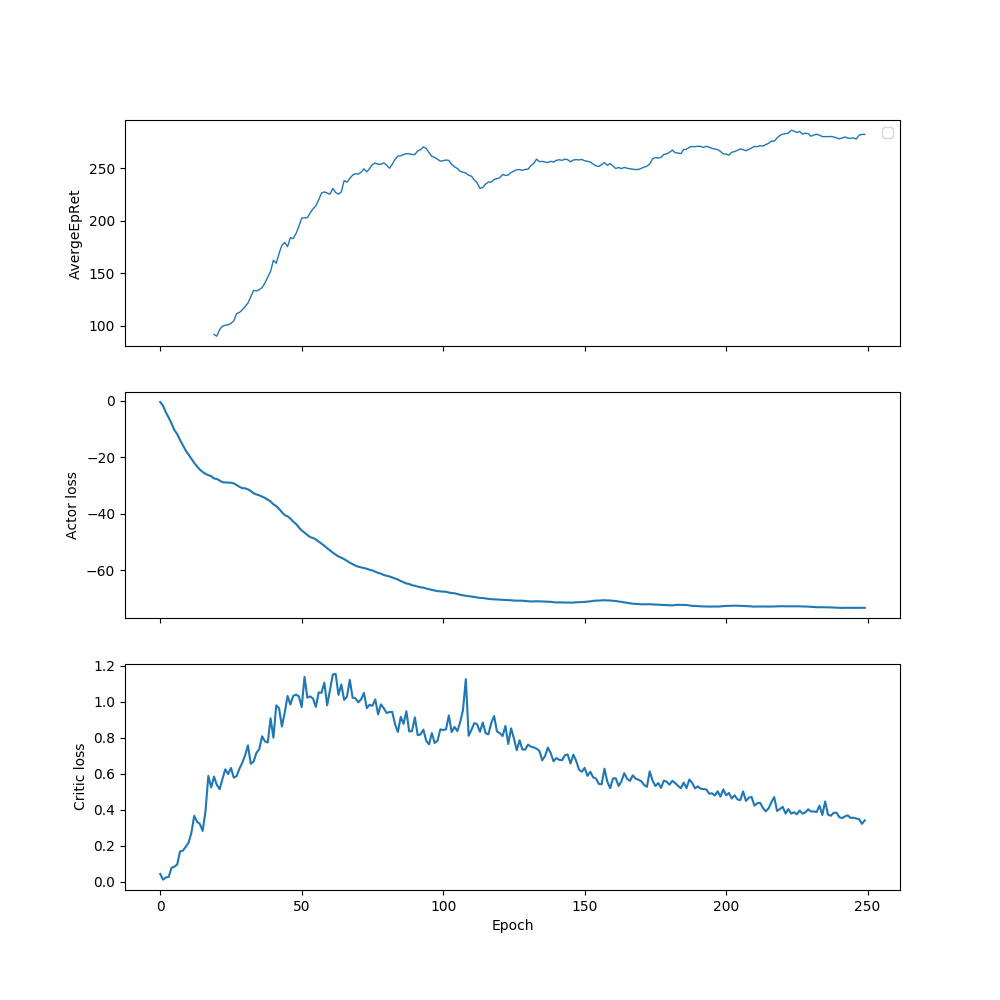

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


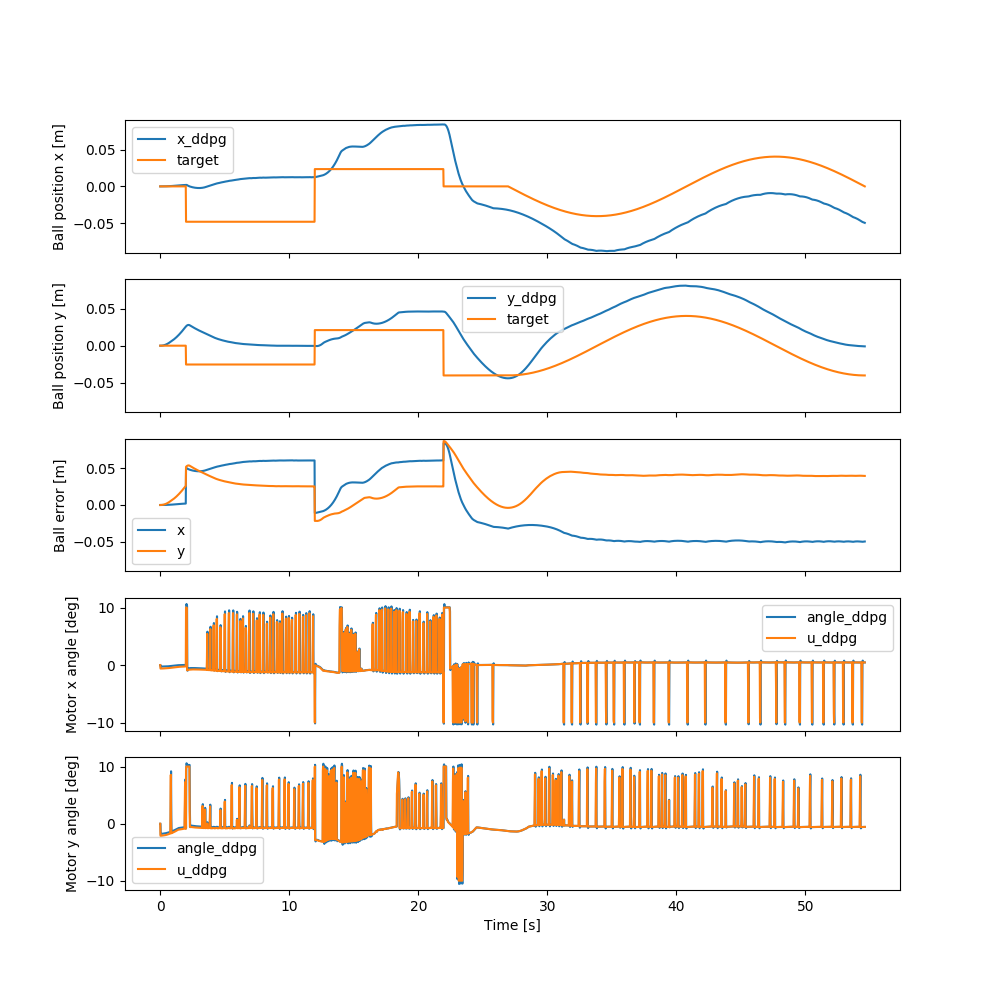

In [16]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100, 50]
activation = torch.nn.ReLU
name='pep_0.6_[100, 50]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.4
hidden_size = [100, 50]
activation = torch.nn.Sigmoid
name='pep_0.4_[100, 50]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100, 100]
activation = torch.nn.ReLU
name='pep_0.6_[100, 100]_relu'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)

In [ ]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100, 100]
activation = torch.nn.Sigmoid
name='pep_0.6_[100, 100]_sigmoid'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name)